In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from wind_tools import *
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib
from windrose import WindroseAxes
#matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt
sns.set(style='whitegrid', context='talk')
import plotly.express as px

matplotlib.rcParams['figure.figsize'] = (20,12)

# Load High Freq data

In [ ]:
import matplotlib.font_manager

In [ ]:
matplotlib.rcParams['font.sans-serif'] = "Open-Sans"

In [ ]:
date_range = "index > '2020-08-13'"

In [ ]:
in_dir = Path('2020_data/data_field_v2_from_20208010/preprocessed/')
names = [
    '*_WM_174605_com1.csv',
     "*_TRS_M00506_com3.csv",
    "*_TRS_M00507_com2.csv",
]

In [ ]:
def maybe_interpolate(df, max_tol=0.1):
    if df.iloc[:, 0].isna().sum() < len(df)*max_tol:
        return df.interpolate()
    else:
        print("not enough data")
        return df

In [ ]:
def make_long_df(name_re):
    return pd.concat([maybe_interpolate(load_high_freq_data(f)) for f in in_dir.glob(name_re)])

In [ ]:
wm1, m6, m7 = map(lambda x: make_long_df(x)
                  .query(date_range)
                  .pipe(maybe_interpolate)
                  .pipe(add_wind_dir)
                  .pipe(add_wind_speed)
                  .pipe(add_angle_attack)
                  .pipe(add_hor_wind_speed),
                  names)

## Calc Dir and AoA stats

In [ ]:
wm1_dir_stats = wm1.resample('30min').wind_dir.apply(
    lambda x: x.groupby(pd.cut(x, bins=range(0, 361, 10))).size() # to include 360 need to add one to the range
)

wm1_dir_stats.index.names = ['half_hour', 'dir_bin']

wm1_dir_stats.columns = ['n']

wm1_dir_stats

half_hour            dir_bin   
2020-08-13 00:00:00  (0, 10]       502
                     (10, 20]      636
                     (20, 30]      681
                     (30, 40]      692
                     (40, 50]      503
                                  ... 
2020-08-24 15:30:00  (310, 320]    473
                     (320, 330]    359
                     (330, 340]    189
                     (340, 350]    100
                     (350, 360]     67
Name: wind_dir, Length: 20160, dtype: int64

In [ ]:
wm1_good_dir = filter_by_wind_dir(wm1, 250, 30).resample('30min').sum() / 18000

In [ ]:
wm1_good_dir

2020-08-13 00:00:00    0.225444
2020-08-13 00:30:00    0.100500
2020-08-13 01:00:00    0.040722
2020-08-13 01:30:00    0.007778
2020-08-13 02:00:00    0.003722
                         ...   
2020-08-24 13:30:00    0.728500
2020-08-24 14:00:00    0.635944
2020-08-24 14:30:00    0.521000
2020-08-24 15:00:00    0.531167
2020-08-24 15:30:00    0.673833
Freq: 30T, Name: wind_dir, Length: 560, dtype: float64

In [ ]:
wm1_good_dir.describe()

count    560.000000
mean       0.325335
std        0.264106
min        0.000000
25%        0.071125
50%        0.269083
75%        0.575653
max        0.818222
Name: wind_dir, dtype: float64

In [ ]:
wm1_aoa_stats = wm1.resample('30min').angle_attack.apply(
    lambda x: x.groupby(pd.cut(x, bins=range(-90, 91, 10))).size() # to include 90 need to add one to the range
)

wm1_aoa_stats.index.names = ['half_hour', 'aoa_bin']

wm1_aoa_stats.columns = ['n']

wm1_aoa_stats

half_hour            aoa_bin   
2020-08-13 00:00:00  (-90, -80]     22
                     (-80, -70]     75
                     (-70, -60]    182
                     (-60, -50]    272
                     (-50, -40]    493
                                  ... 
2020-08-24 15:30:00  (40, 50]      332
                     (50, 60]      174
                     (60, 70]      112
                     (70, 80]       44
                     (80, 90]       11
Name: angle_attack, Length: 10080, dtype: int64

In [ ]:
wm1_good_aoa = ((wm1[wm1.w.abs()>.2].angle_attack > -30) & (wm1[wm1.w.abs()>.2].angle_attack < 30)).resample('30min').sum() / 18000

In [ ]:
wm1_good_aoa = ((wm1.angle_attack > -30) & (wm1.angle_attack < 30)).resample('30min').sum() / 18000

In [ ]:
wm1_good_aoa

2020-08-13 00:00:00    0.089556
2020-08-13 00:30:00    0.061833
2020-08-13 01:00:00    0.022444
2020-08-13 01:30:00    0.005944
2020-08-13 02:00:00    0.061278
                         ...   
2020-08-26 06:30:00    0.181667
2020-08-26 07:00:00    0.274500
2020-08-26 07:30:00    0.344167
2020-08-26 08:00:00    0.428500
2020-08-26 08:30:00    0.450500
Freq: 30T, Name: angle_attack, Length: 642, dtype: float64

In [ ]:
plot_info_all=[{'label': 'WM1', 'color': sns.color_palette()[0]}, {'label': 'TrsH', 'color': sns.color_palette()[1]}, {'label': 'TrsV', 'color': sns.color_palette()[2]}]
plot_info_m7 = [{'label': 'WM1', 'color': sns.color_palette()[0]}, {'label': 'TrsV', 'color': sns.color_palette()[2]}]

## Load EP data

In [ ]:
proc_dir = Path("2020_data/data_field_v2_from_20208010/processed/30min")

ep_paths = ["eddypro_WM1_30min_full_output_2020-08-25T121604_exp.csv",
            "eddypro_M506_30min_full_output_2020-08-25T122305_exp.csv",
            "eddypro_TRS_M507_30min_full_output_2020-08-25T120431_exp.csv"]


cache_dir = Path("data_cache")



wind_cols = ['u_unrot','v_unrot', 'w_unrot', 'wind_speed', 'wind_dir', 'Tau', 'H', 'air_temperature', 'u*']
wind_comp_rename = {'u_unrot': 'u', 'v_unrot': 'v', 'w_unrot': 'w', 'air_temperature': 't'}

In [ ]:
wm1ep, m6ep, m7ep = map(
    lambda p: load_ep_cache(proc_dir / p, cache_dir= cache_dir)
    .query(date_range)
    .loc[:,wind_cols]
    .rename(columns=wind_comp_rename),
    ep_paths)

In [ ]:
wm1ep

u         v         w  wind_speed  wind_dir  \
date_time                                                                 
2020-08-13 00:30:00 -0.119133 -0.144078  0.023493    0.188436  328.4370   
2020-08-13 01:00:00 -0.025795  0.099129 -0.028449    0.106318   46.5435   
2020-08-13 01:30:00 -0.067851 -0.023952 -0.008345    0.072461  335.2050   
2020-08-13 02:00:00 -0.101247 -0.022590  0.007594    0.104050  332.9120   
2020-08-13 02:30:00 -0.311380 -0.008679  0.026105    0.312621  347.2060   
...                       ...       ...       ...         ...       ...   
2020-08-24 14:00:00  0.569875 -2.047630 -0.138565    2.129990  257.3640   
2020-08-24 14:30:00  0.472314 -2.151450 -0.023897    2.202890  260.1850   
2020-08-24 15:00:00  0.043367 -2.392710  0.066899    2.394130  270.9670   
2020-08-24 15:30:00  0.072662 -2.161720 -0.027387    2.163260  269.6240   
2020-08-24 16:00:00  0.625276 -2.045540 -0.096164    2.141150  257.2990   

                          Tau          H        t        u*  
date_time                                                    
2020-08-13 00:30:00  0.010105   -3.70411  298.017  0.094176  
2020-08-13 01:00:00  0.019126  -13.26780  298.138  0.129591  
2020-08-13 01:30:00  0.017514  -11.26680  298.473  0.124083  
2020-08-13 02:00:00  0.002515    5.02356  297.608  0.046950  
2020-08-13 02:30:00  0.007737   -0.40778  296.482  0.082197  
...                       ...        ...      ...       ...  
2020-08-24 14:00:00 -0.112127  243.22500  305.842  0.317807  
2020-08-24 14:30:00 -0.271925  337.36900  305.969  0.495022  
2020-08-24 15:00:00 -0.404275  340.22200  305.616  0.603236  
2020-08-24 15:30:00 -0.261856  290.35500  305.324  0.485258  
2020-08-24 16:00:00 -0.304101  244.54500  304.701  0.522405  

[560 rows x 9 columns]

## Wind Basic Plots

### Compoments

Text(0.5, 0.98, 'Wind Master vs Trisonca Vertical (m507)')

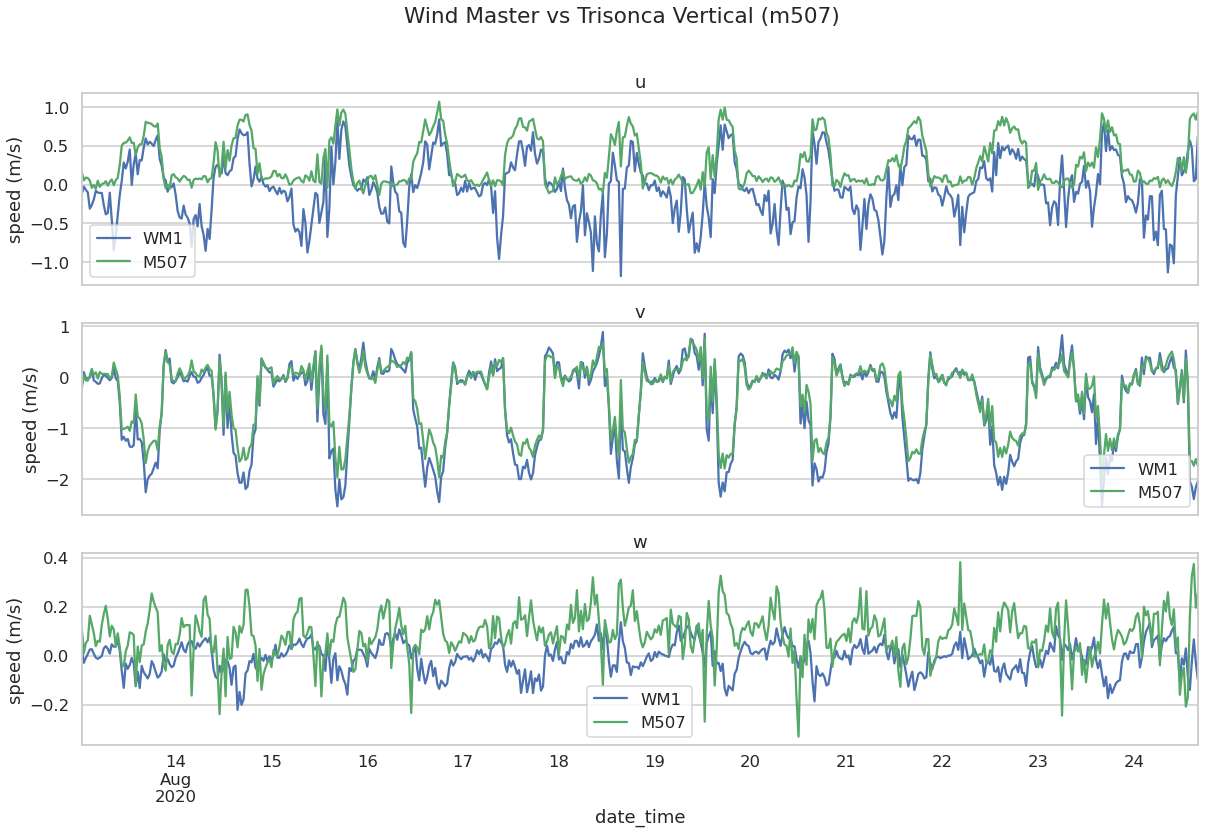

In [ ]:
axes = plot_components([wm1ep, m7ep], vertical=False, plot_info=plot_info_m7)
[ax.set_ylabel("speed (m/s)") for ax in axes]
plt.suptitle("Wind Master vs Trisonca Vertical (m507)")

Text(0.5, 0.98, 'Wind Master vs Trisonca Vertical (m506)')

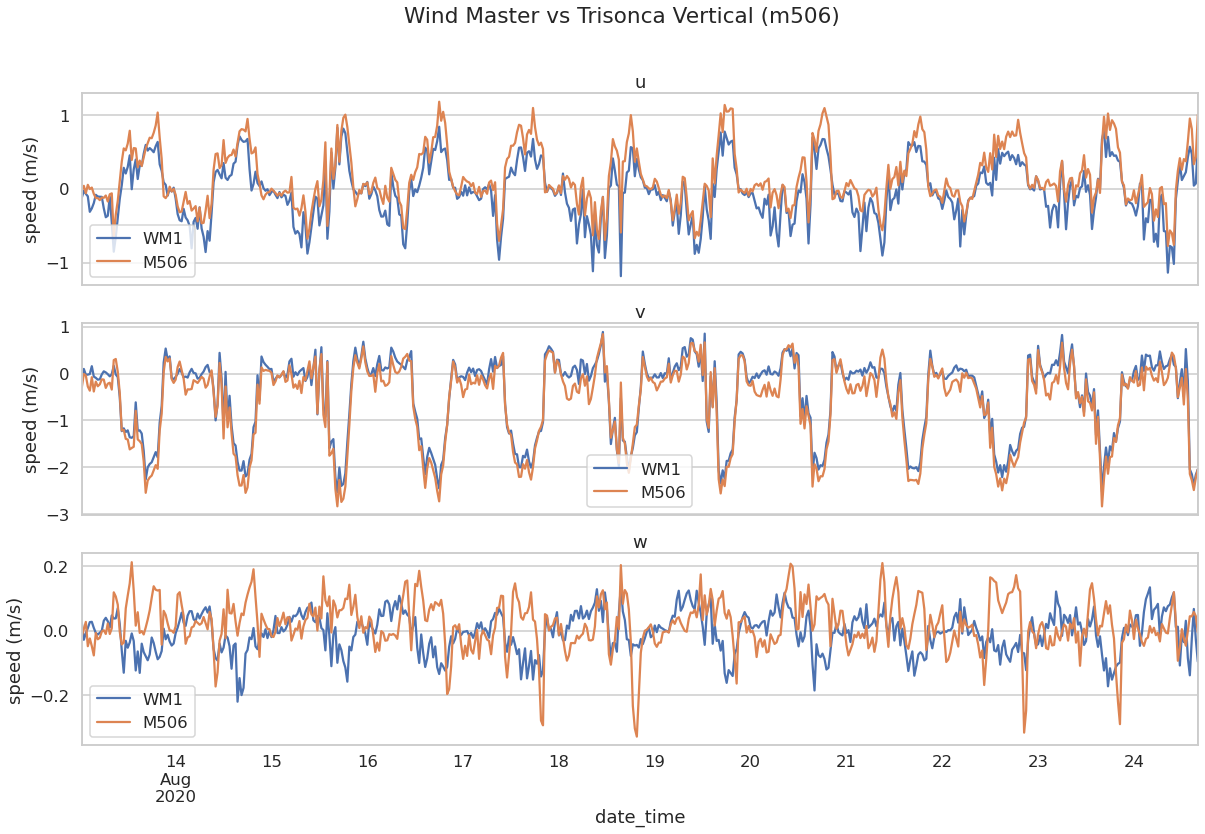

In [ ]:
axes = plot_components([wm1ep, m6ep], vertical=False, plot_info=plot_info_all)
[ax.set_ylabel("speed (m/s)") for ax in axes]
plt.suptitle("Wind Master vs Trisonca Vertical (m506)")

#### Filtered data

array([<AxesSubplot:title={'center':'u'}>,
       <AxesSubplot:title={'center':'v'}>,
       <AxesSubplot:title={'center':'w'}>], dtype=object)

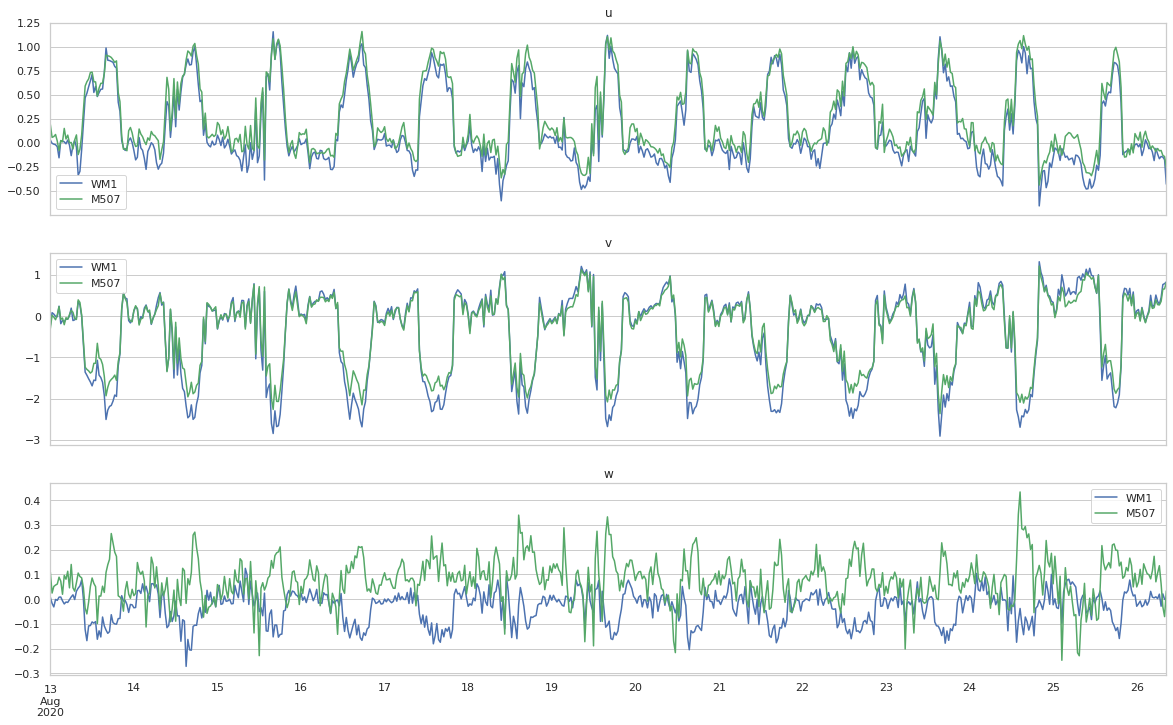

In [ ]:
plot_components(resample([wm1f, m7f], '30min'), vertical=False, plot_info=plot_info_m7)

array([<AxesSubplot:title={'center':'u'}>,
       <AxesSubplot:title={'center':'v'}>,
       <AxesSubplot:title={'center':'w'}>], dtype=object)

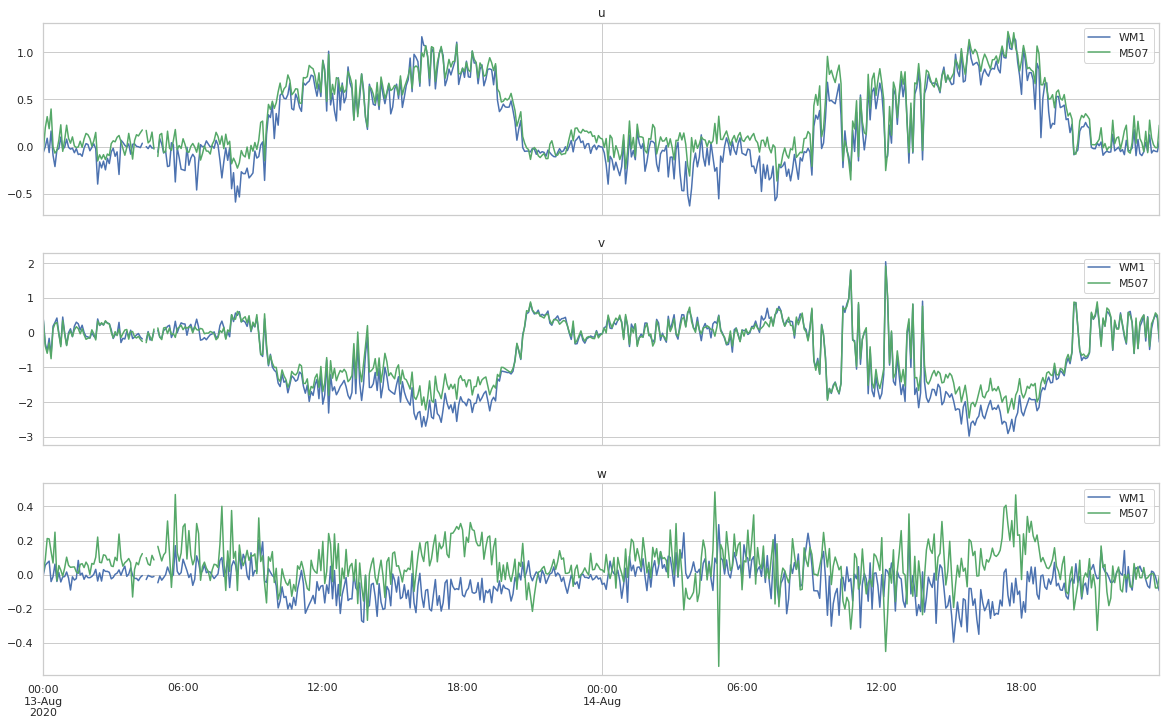

In [ ]:
plot_components(resample([wm1f.loc[:'2020-08-14'], m7f.loc[:'2020-08-14']], '5min'), vertical=False, plot_info=plot_info_m7)

In [ ]:
dfs = resample([wm1f.loc['2020-08-14':'2020-08-15'], m7f.loc['2020-08-14':'2020-08-15']], '5min')
dfs[0][dfs[0].isna()]

u   v   w   t  wind_dir  wind_speed  angle_attack  \
2020-08-14 00:00:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-14 00:05:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-14 00:10:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-14 00:15:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-14 00:20:00 NaN NaN NaN NaN       NaN         NaN           NaN   
...                  ..  ..  ..  ..       ...         ...           ...   
2020-08-15 23:35:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-15 23:40:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-15 23:45:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-15 23:50:00 NaN NaN NaN NaN       NaN         NaN           NaN   
2020-08-15 23:55:00 NaN NaN NaN NaN       NaN         NaN           NaN   

                     wind_speed_hor  
2020-08-14 00:00:00             NaN  
2020-08-14 00:05:00             NaN  
2020-08-14 00:10:00             NaN  
2020-08-14 00:15:00             NaN  
2020-08-14 00:20:00             NaN  
...                             ...  
2020-08-15 23:35:00             NaN  
2020-08-15 23:40:00             NaN  
2020-08-15 23:45:00             NaN  
2020-08-15 23:50:00             NaN  
2020-08-15 23:55:00             NaN  

[576 rows x 8 columns]

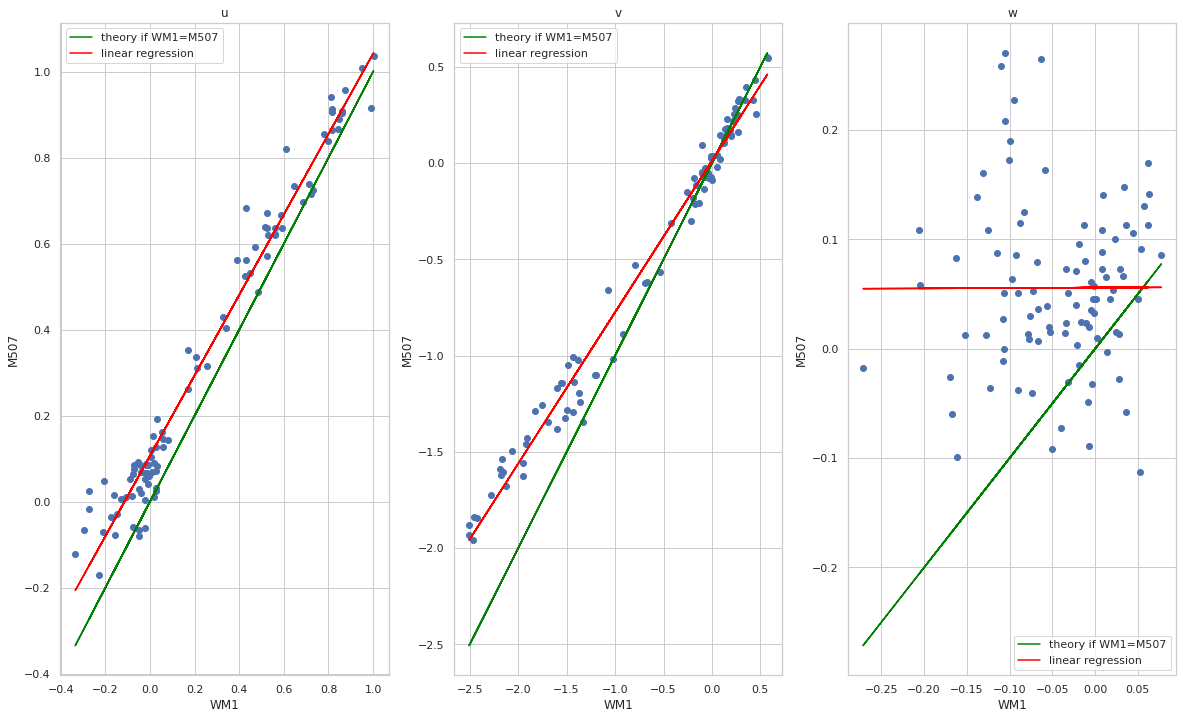

In [ ]:
plot_components_scatter([x.dropna() for x in resample([wm1f.loc[:'2020-08-14'], m7f.loc[:'2020-08-14']], '30min')], plot_info=plot_info_m7)

In [ ]:
filt = filter_by_wind_dir(wm1, 250, 30)
wm1f = wm1[filt]
m7f = m7[filt]

/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

array([<AxesSubplot:title={'center':'w'}>], dtype=object)

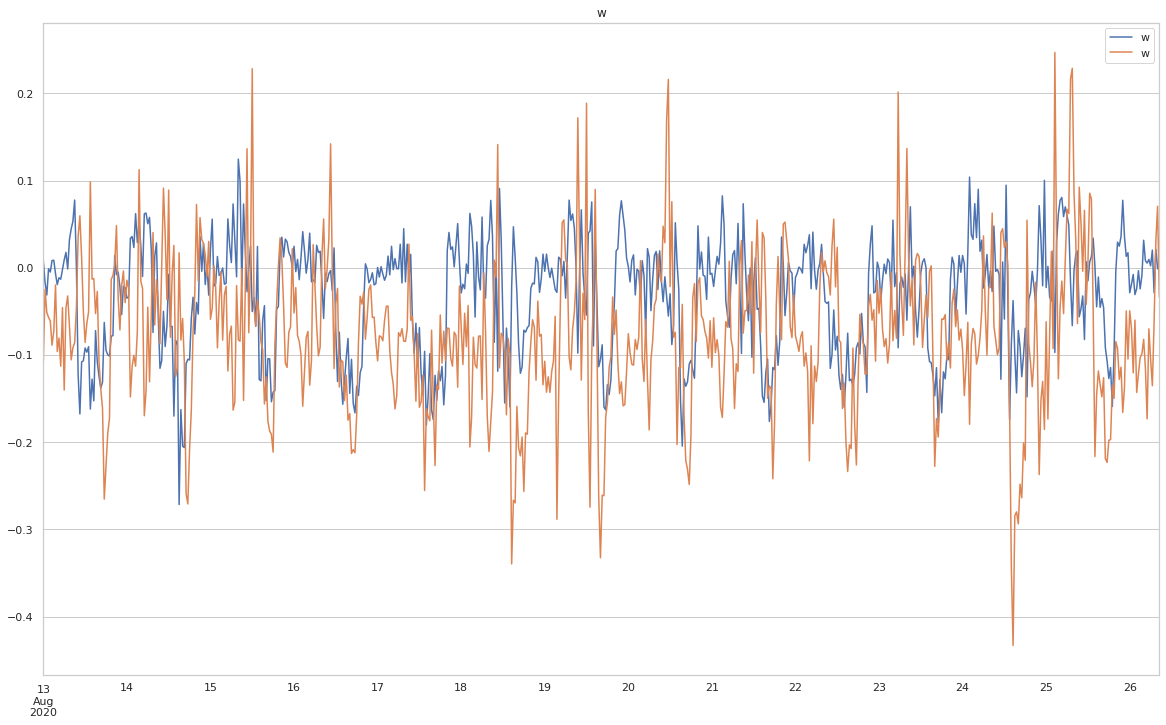

In [ ]:
plot_components(resample([wm1f, -m7f], '30min'), ['w'], vertical=False)

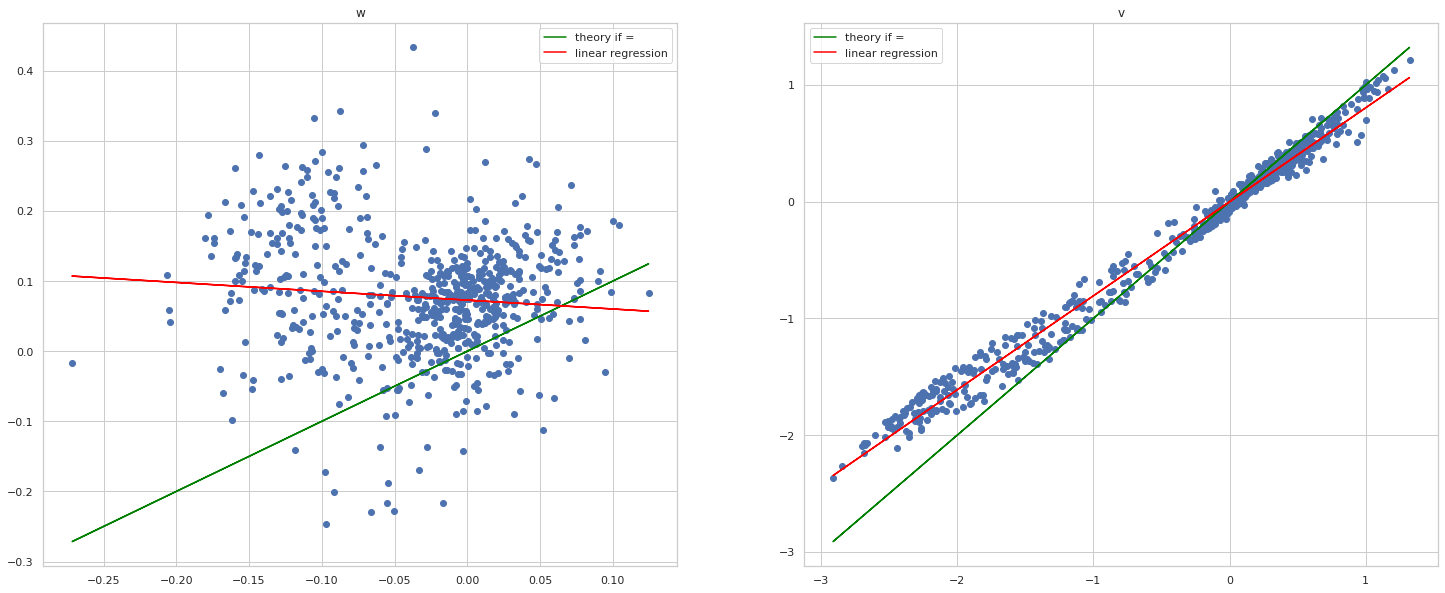

In [ ]:
plot_components_scatter(resample([wm1f, m7f], '30min'), ['w', 'v'], figsize=(25,10))

In [ ]:
plot_components(resample([wm1f, m7epf], '30min'), vertical=False, plot_info=plot_info_3)

NameError: name 'wm1f' is not defined

## Wind speed

### M507

Text(0, 0.5, 'speed (m/s)')

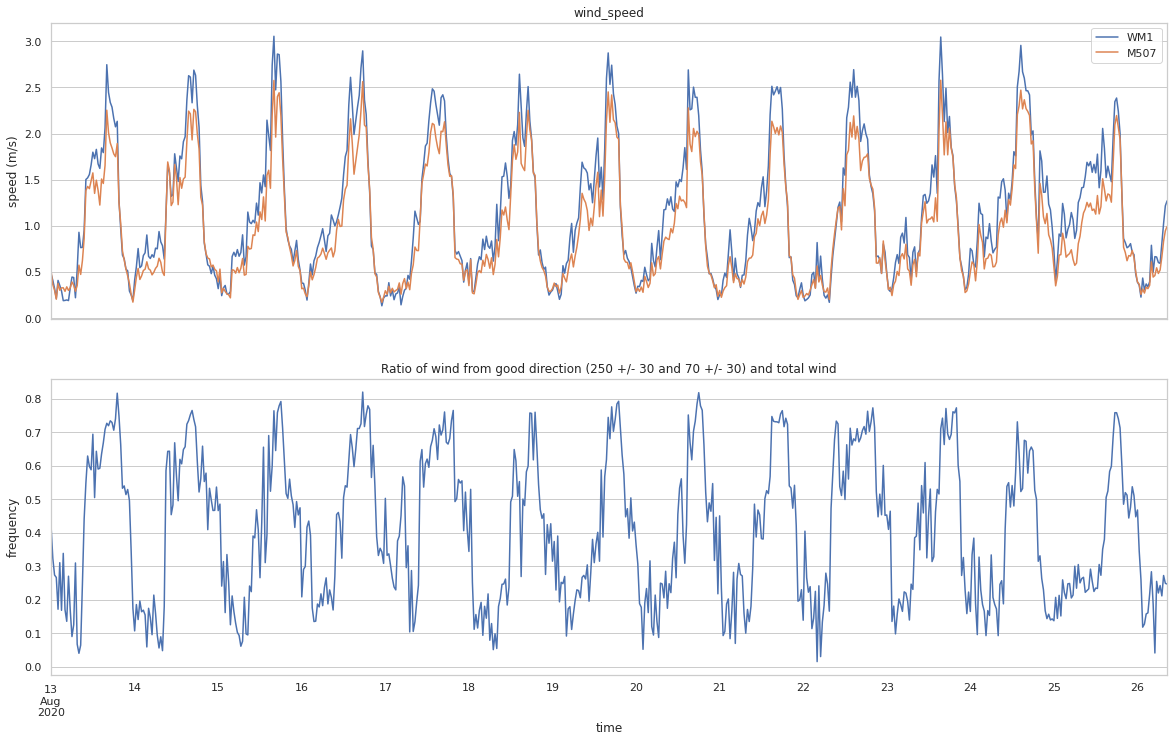

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([d30m['wm1'], d30m['m7']], ['wind_speed'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M507'}])
wm1_good_dir.plot(ax=axes[1])
axes[1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")
axes[1].set_xlabel("time")
axes[1].set_ylabel("frequency")
axes[0].set_ylabel("speed (m/s)")

Text(0, 0.5, 'frequency')

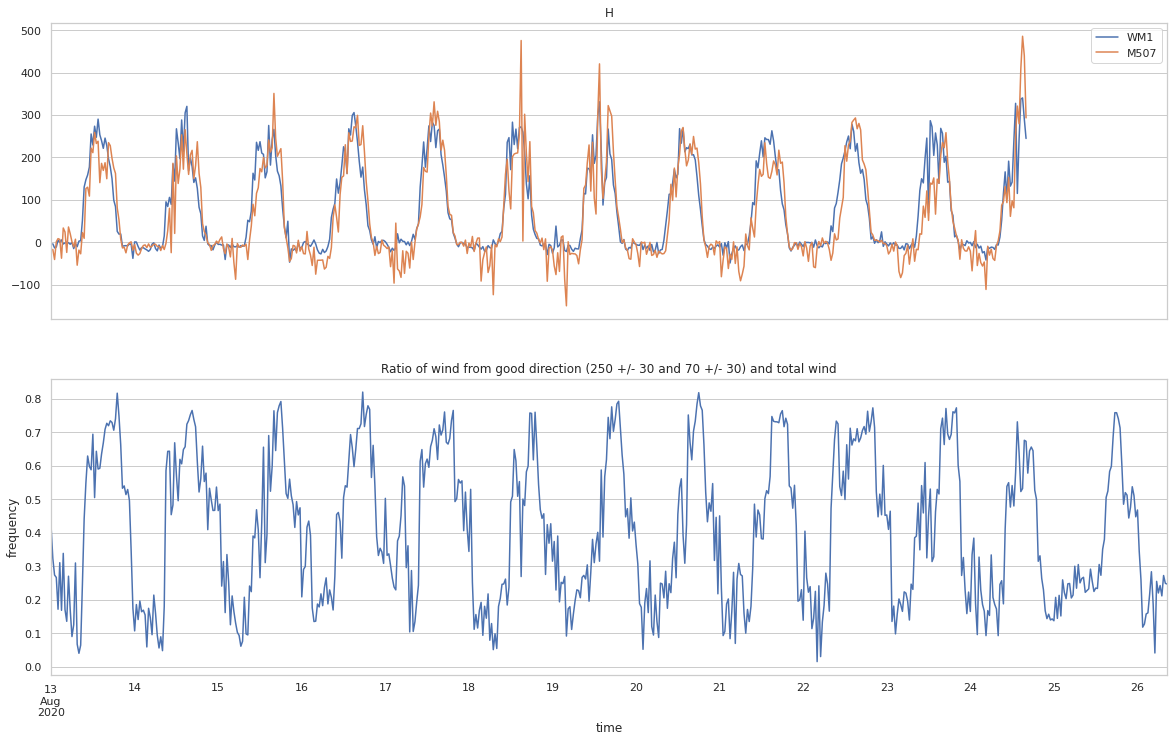

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m7ep], ['H'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M507'}])
wm1_good_dir.plot(ax=axes[1])
axes[1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")
axes[1].set_xlabel("time")
axes[1].set_ylabel("frequency")

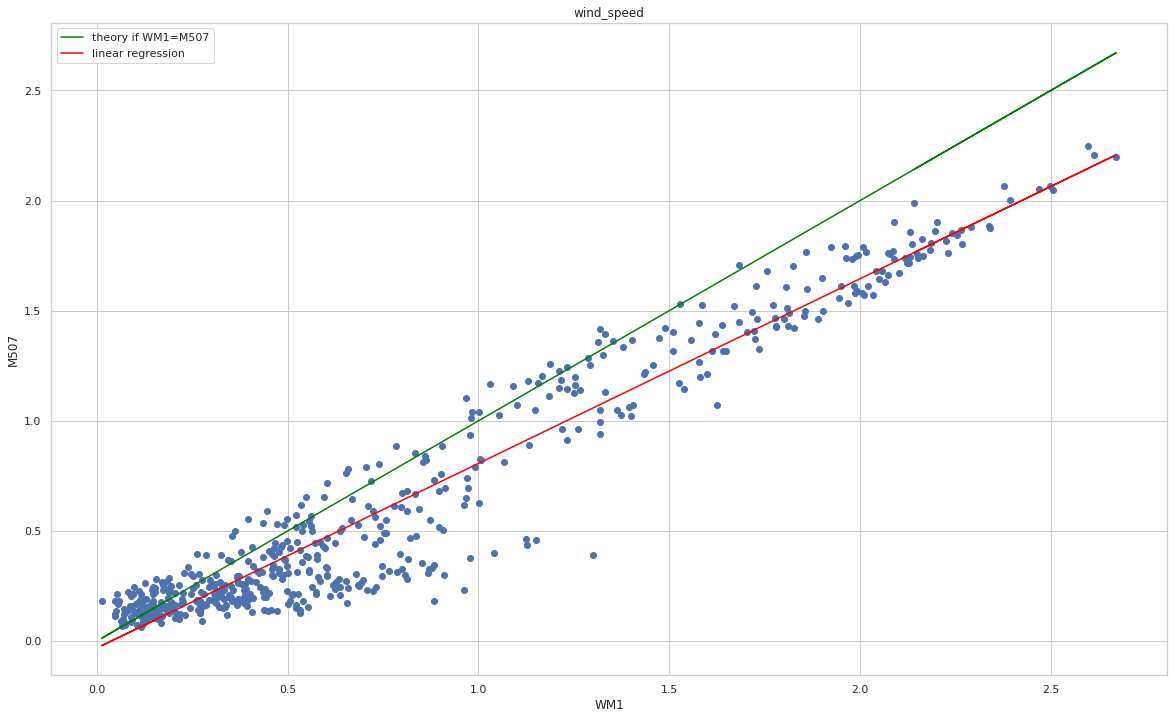

In [ ]:
plot_components_scatter([wm1ep, m7ep], ['wind_speed'], plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

### M506

Text(0, 0.5, 'speed (m/s)')

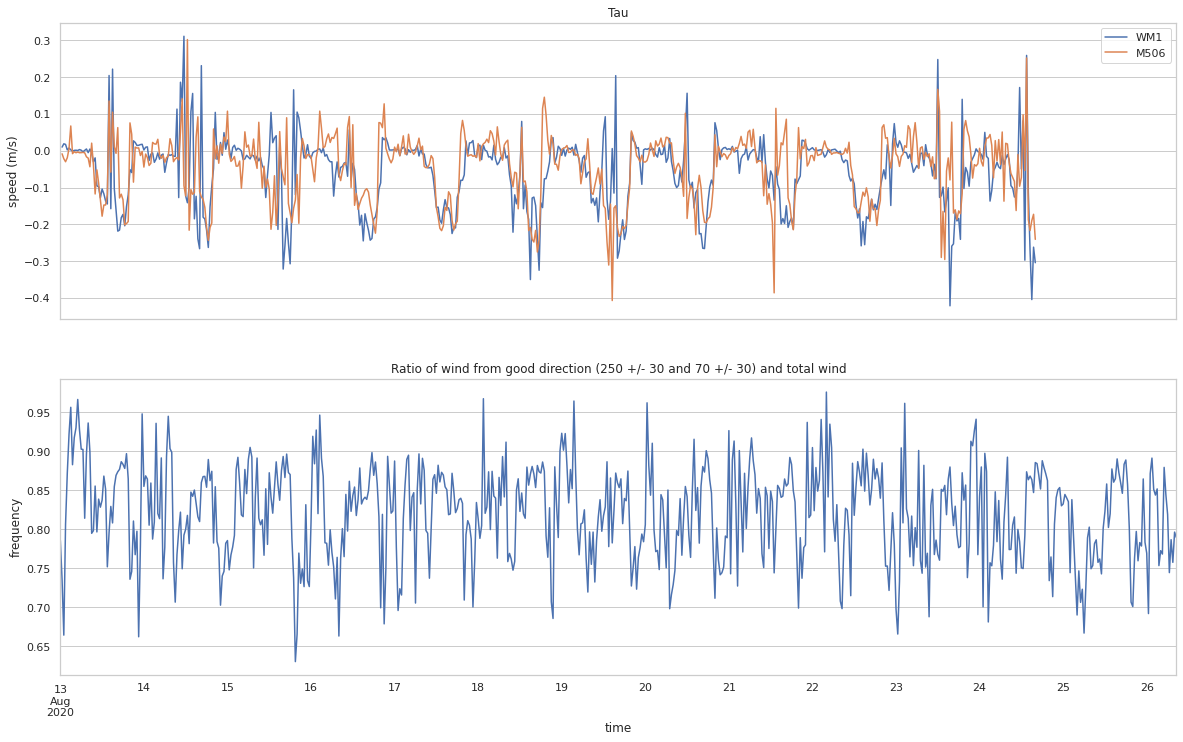

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m6ep], ['Tau'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M506'}])
wm1_good_aoa.plot(ax=axes[1])
axes[1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")
axes[1].set_xlabel("time")
axes[1].set_ylabel("frequency")
axes[0].set_ylabel("speed (m/s)")


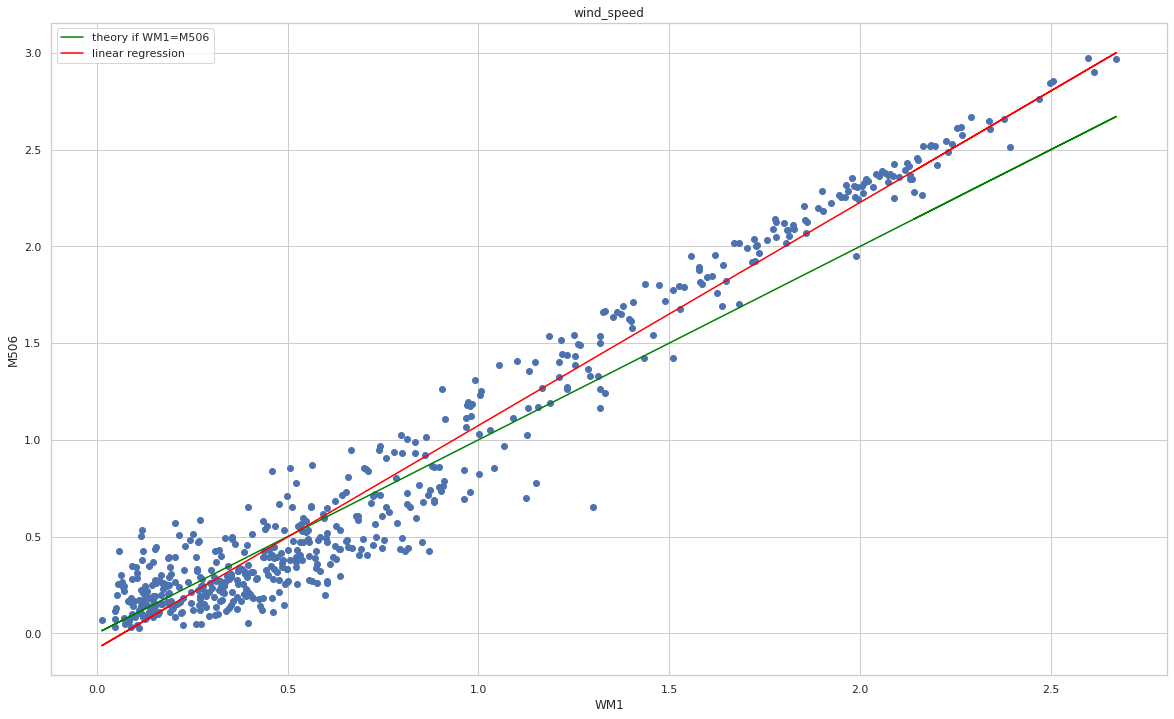

In [ ]:
plot_components_scatter([wm1ep, m6ep], ['wind_speed'], plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

## Tau

### M507

<AxesSubplot:>

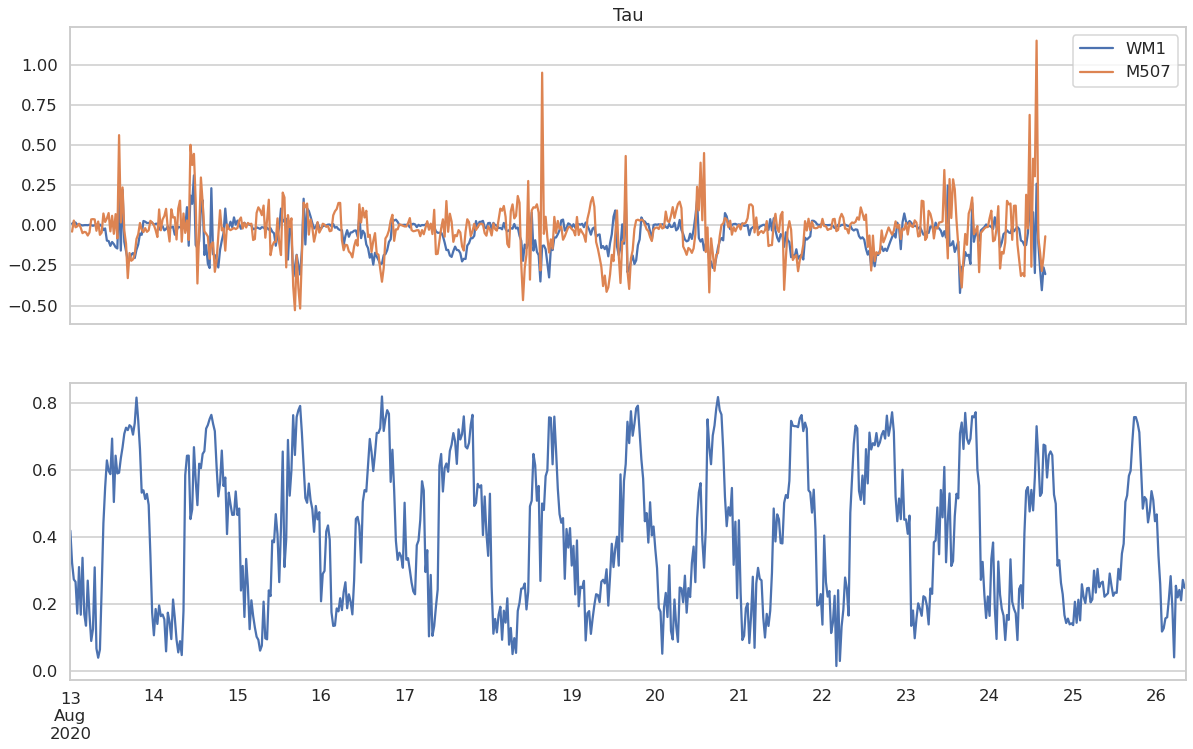

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m7ep], ['Tau'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M507'}])
wm1_good_dir.plot(ax=axes[1])

Text(0.5, 0.98, 'Momentum Flux of Wind Master vs Trisonca Vertical (m507)')

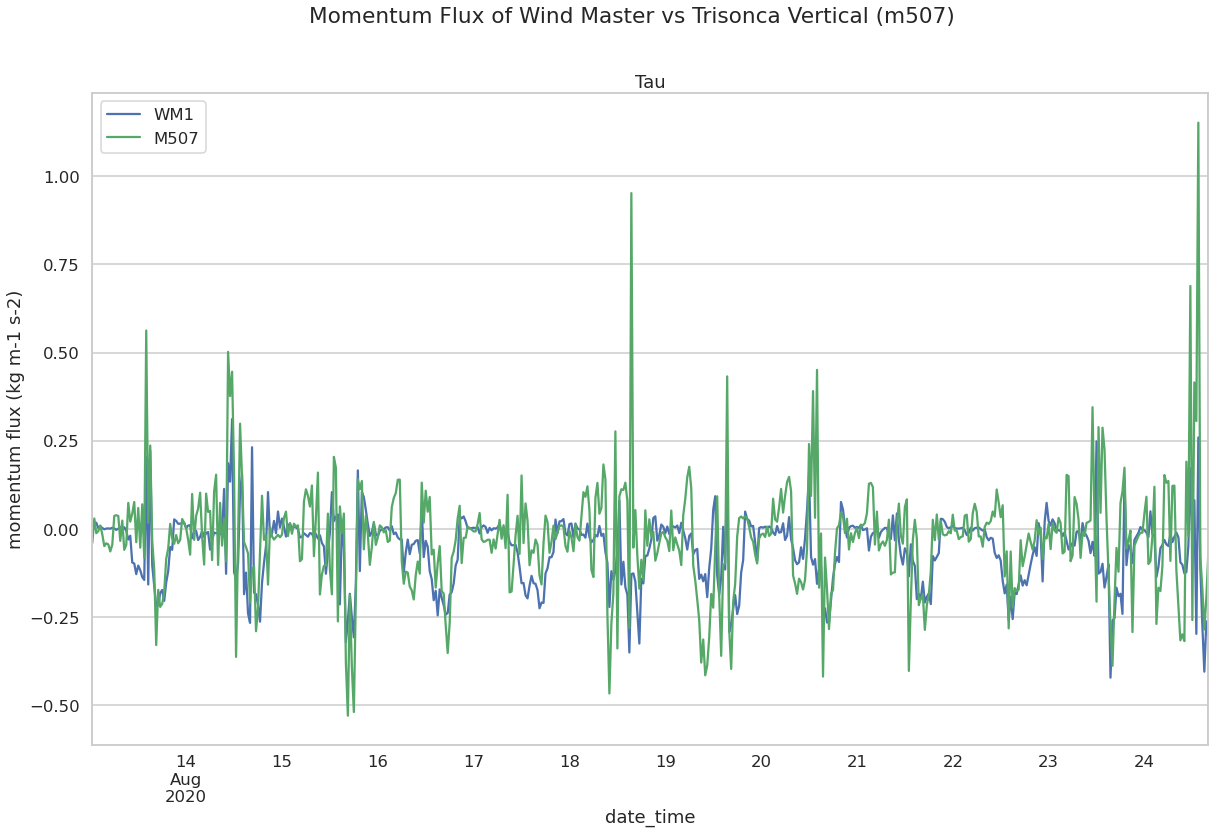

In [ ]:
ax = plot_components([wm1ep, m7ep], ['Tau'], plot_info=plot_info_m7)
ax[0].set_ylabel("momentum flux (kg m-1 s-2)")
plt.suptitle("Momentum Flux of Wind Master vs Trisonca Vertical (m507)")

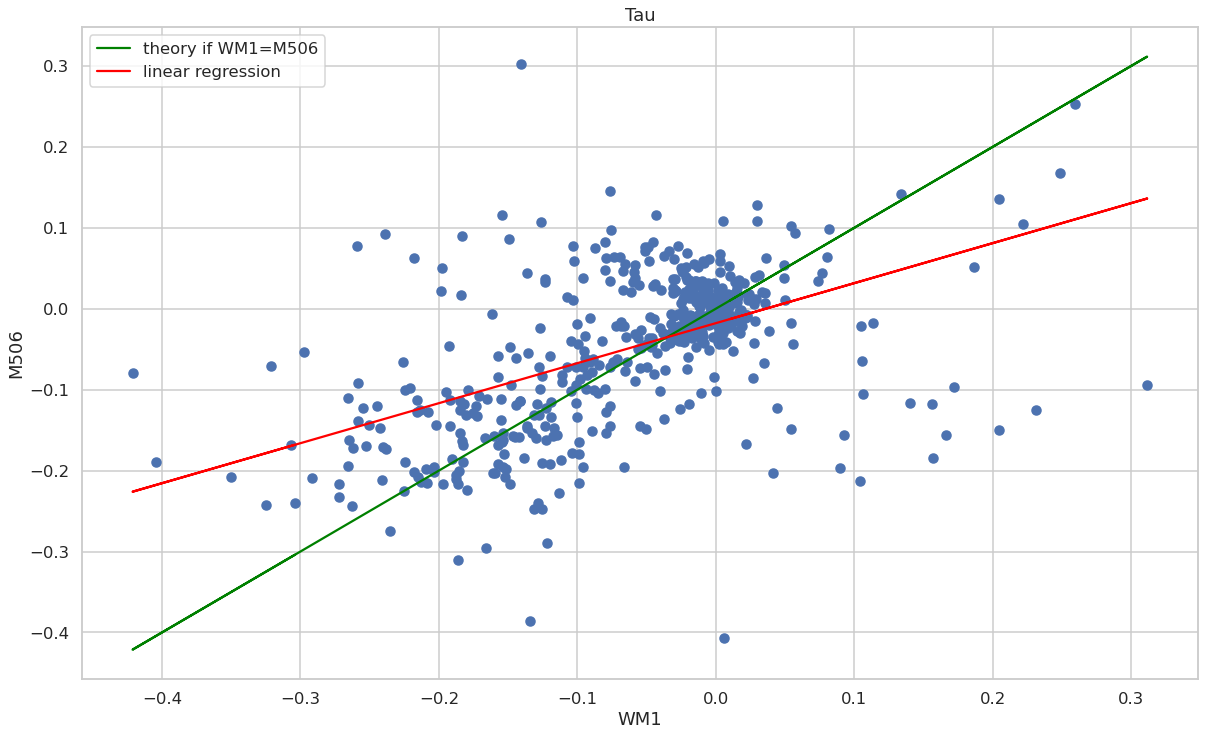

In [ ]:
plot_components_scatter([wm1ep, m6ep], ['Tau'], plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

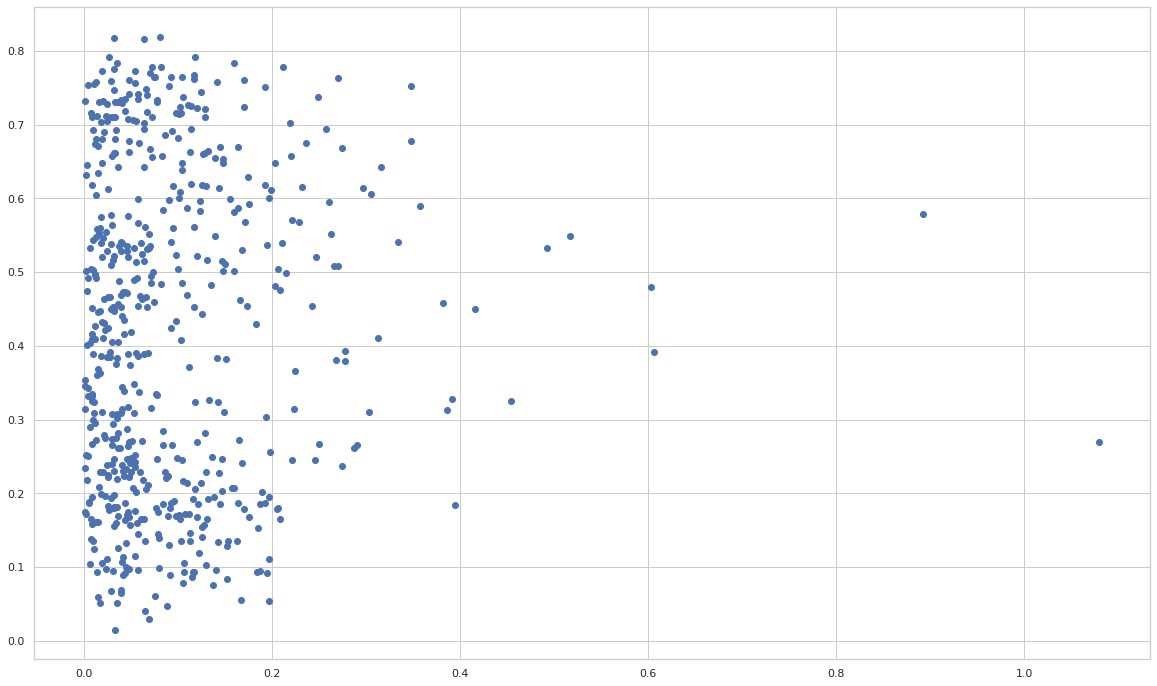

In [ ]:
get_ax().scatter((wm1ep.Tau - m7ep.Tau).abs(), wm1_good_dir)

### M506

Text(0.5, 1.0, 'Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind')

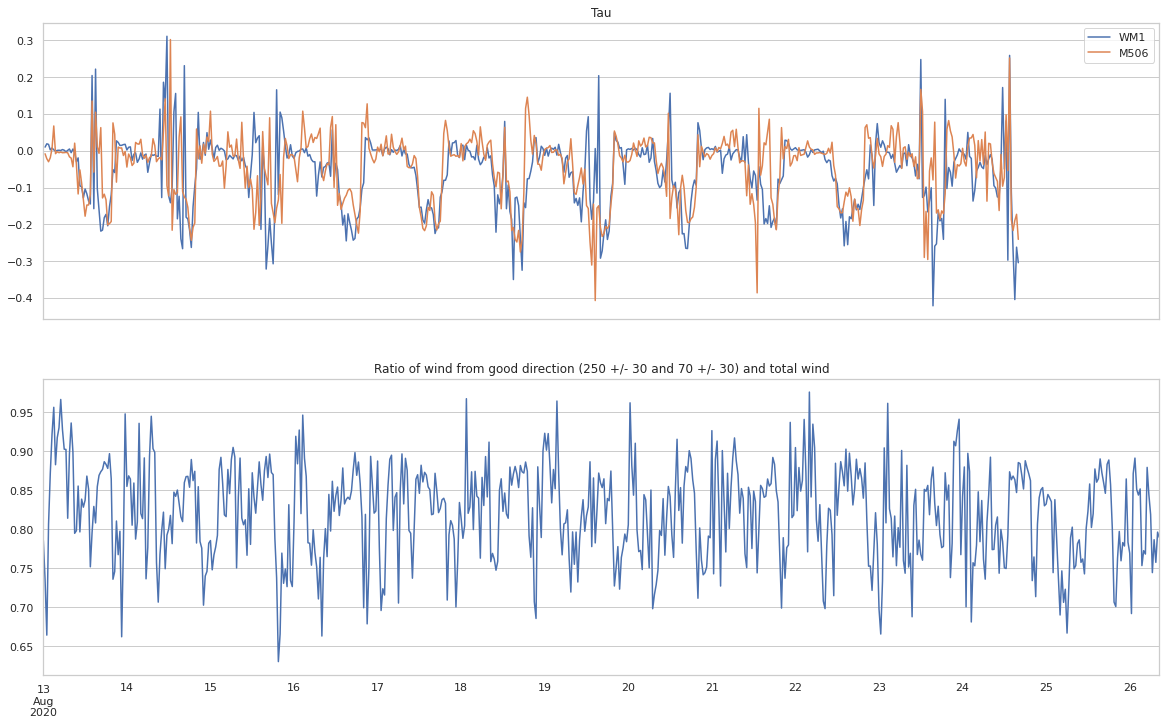

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m6ep], ['Tau'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M506'}])
wm1_good_aoa.plot(ax=axes[1])

axes[1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")


Text(0.5, 1.0, 'Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind')

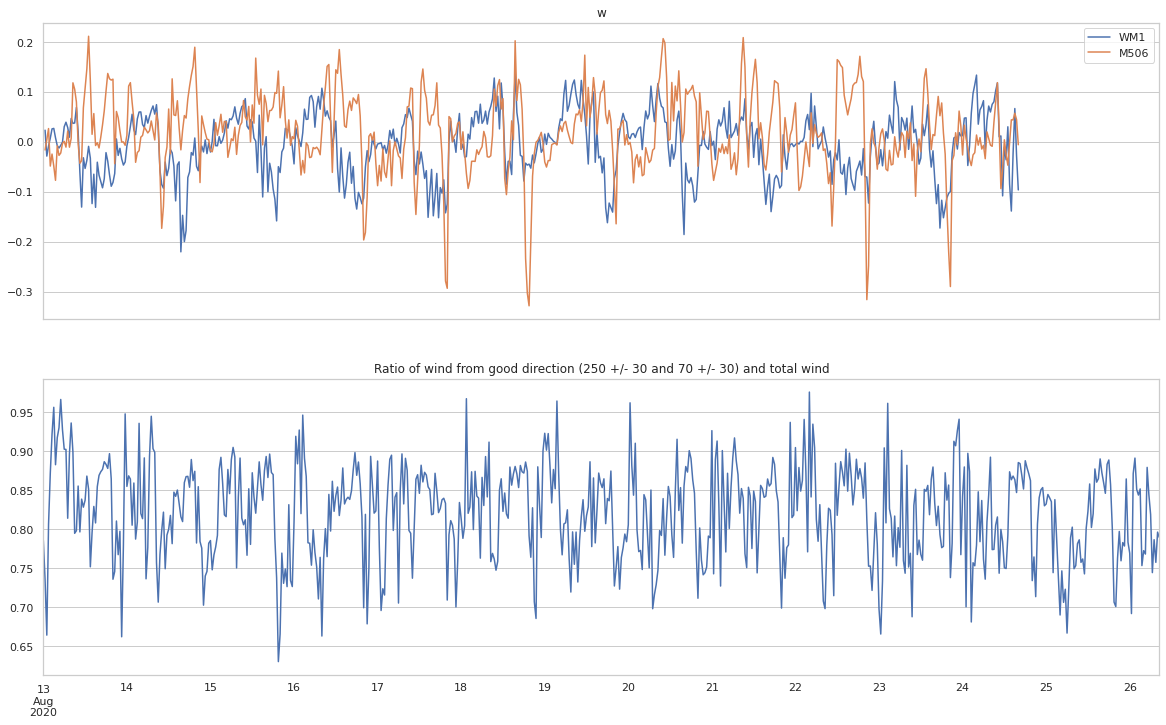

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m6ep], ['w'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M506'}])
wm1_good_aoa.plot(ax=axes[1])

axes[1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")


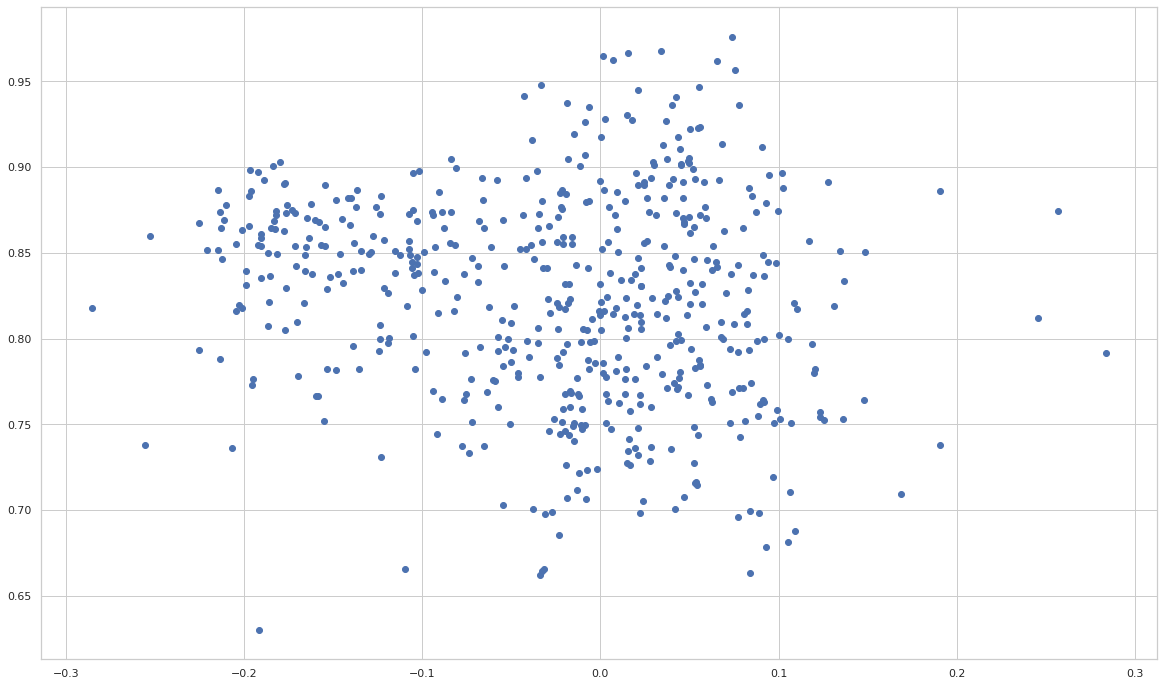

In [ ]:
get_ax().scatter(wm1ep.w-m6ep.w, wm1_good_aoa[wm1ep.index])

## H

Text(0.5, 0.98, 'Sensible Heat Flux of Wind Master vs Trisonca Vertical (m507)')

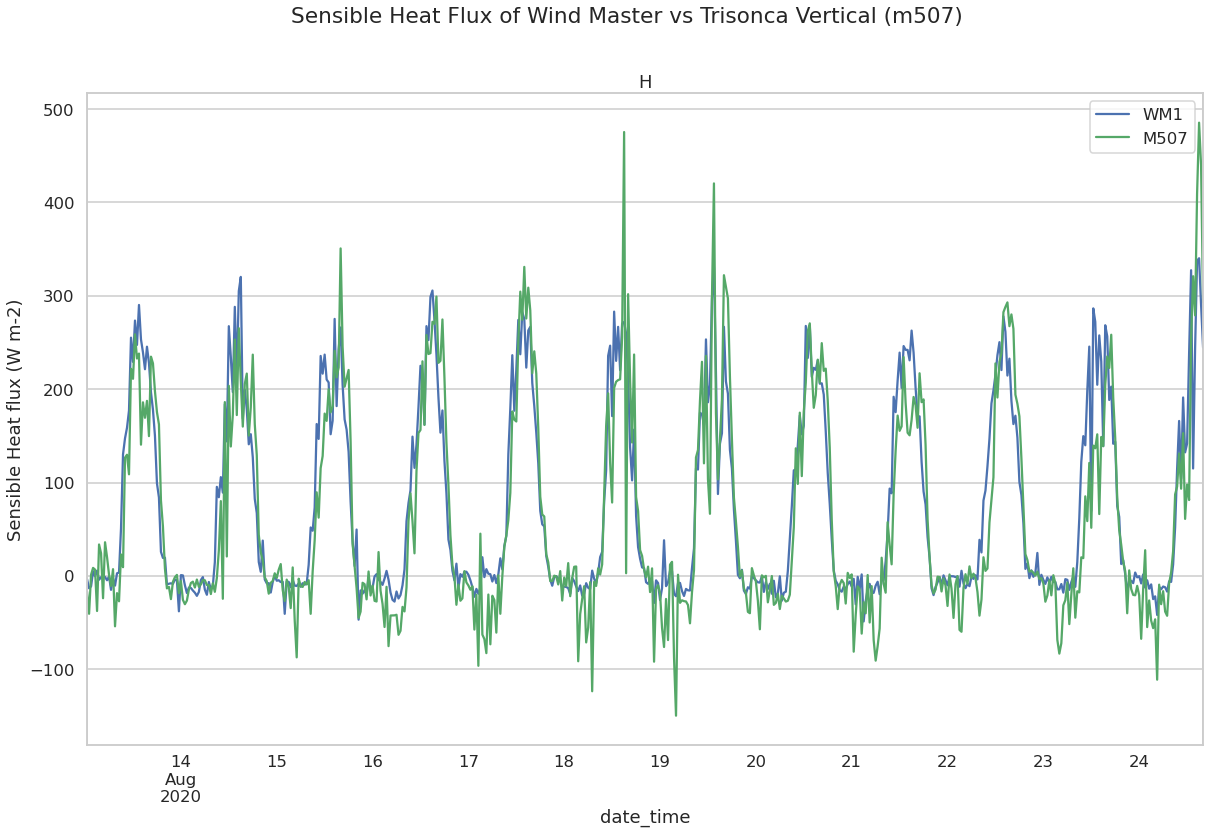

In [ ]:
ax = plot_components([wm1ep, m7ep], ['H'], plot_info=plot_info_m7)
ax[0].set_ylabel("Sensible Heat flux (W m-2)")
plt.suptitle("Sensible Heat Flux of Wind Master vs Trisonca Vertical (m507)")

Text(0, 0.5, 'speed (m/s)')

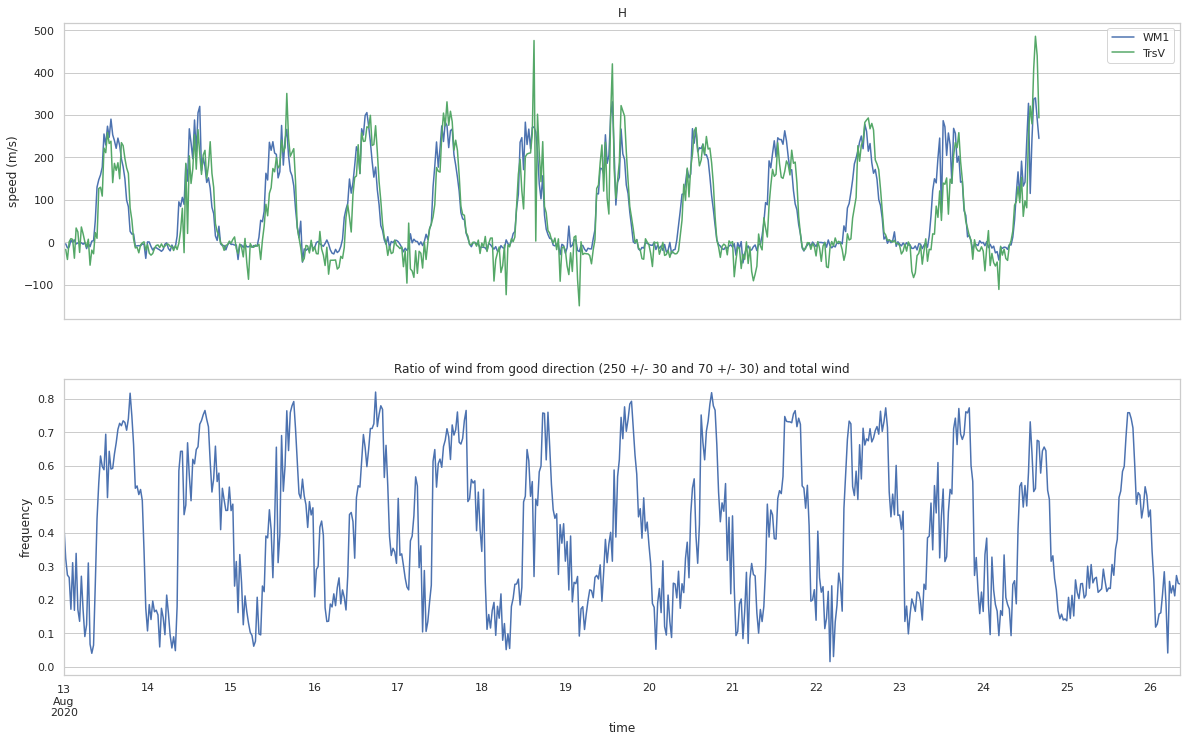

In [ ]:
sns.set_context("notebook")
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m7ep], ['H'], ax=axes[0], plot_info=plot_info_m7)
wm1_good_dir.plot(ax=axes[1])
axes[1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")
axes[1].set_xlabel("time")
axes[1].set_ylabel("frequency")
axes[0].set_ylabel("speed (m/s)")


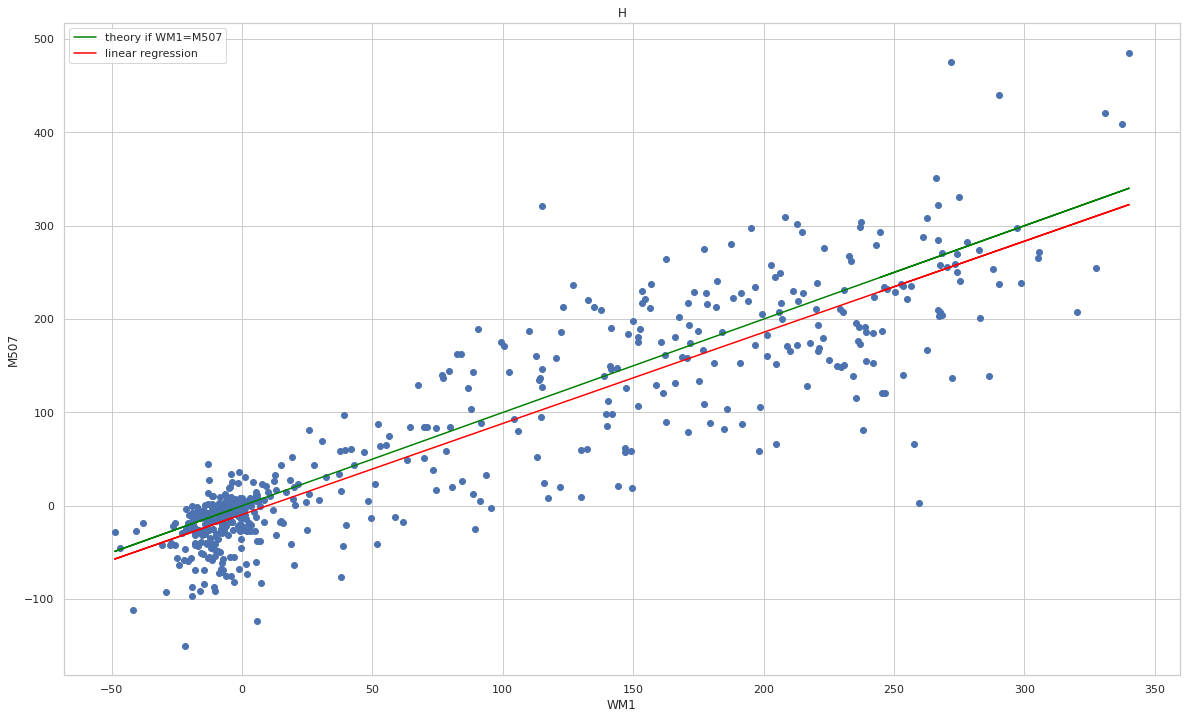

In [ ]:
plot_components_scatter([wm1ep, m7ep], ['H'], plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

Text(0, 0.5, 'speed (m/s)')

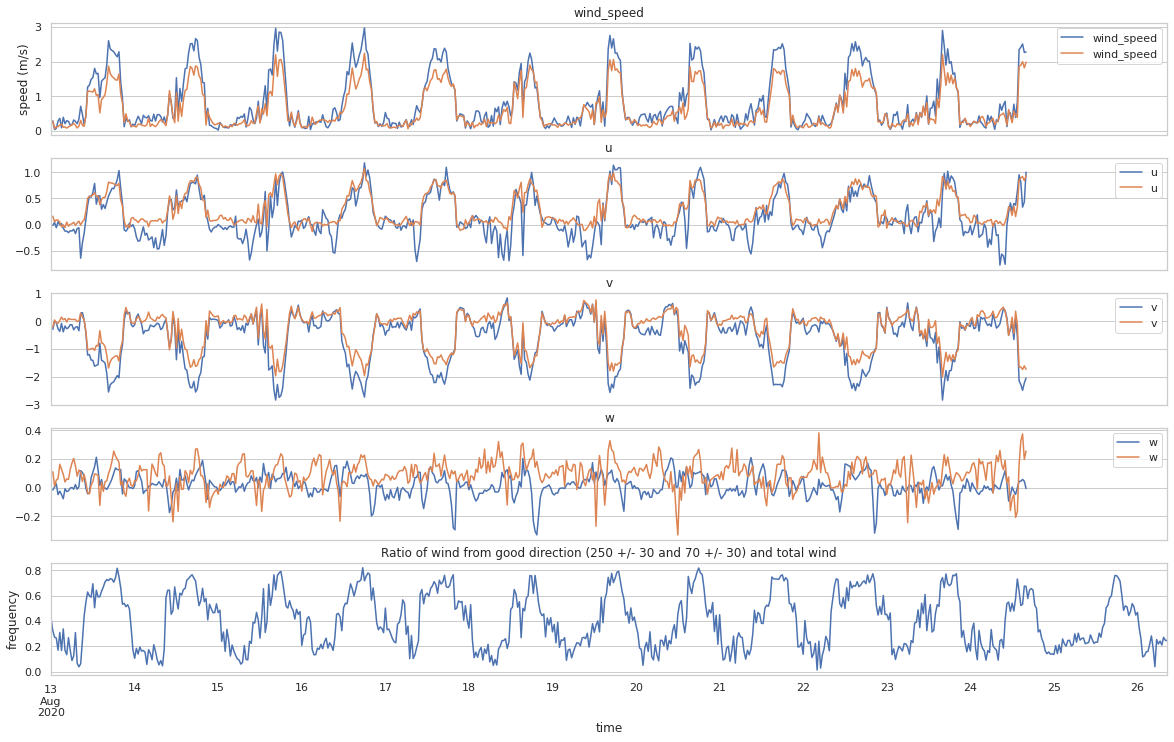

In [ ]:
sns.set_context("notebook")
fig, axes = plt.subplots(5,1, sharex=True)
plot_components([m6ep, m7ep], ['wind_speed', 'u', 'v', 'w'], ax=axes, vertical=False)
wm1_good_dir.plot(ax=axes[-1])
axes[-1].set_title("Ratio of wind from good direction (250 +/- 30 and 70 +/- 30) and total wind")
axes[-1].set_xlabel("time")
axes[-1].set_ylabel("frequency")
axes[0].set_ylabel("speed (m/s)")


In [ ]:
get_ax().scatter(m7ep.v - m)

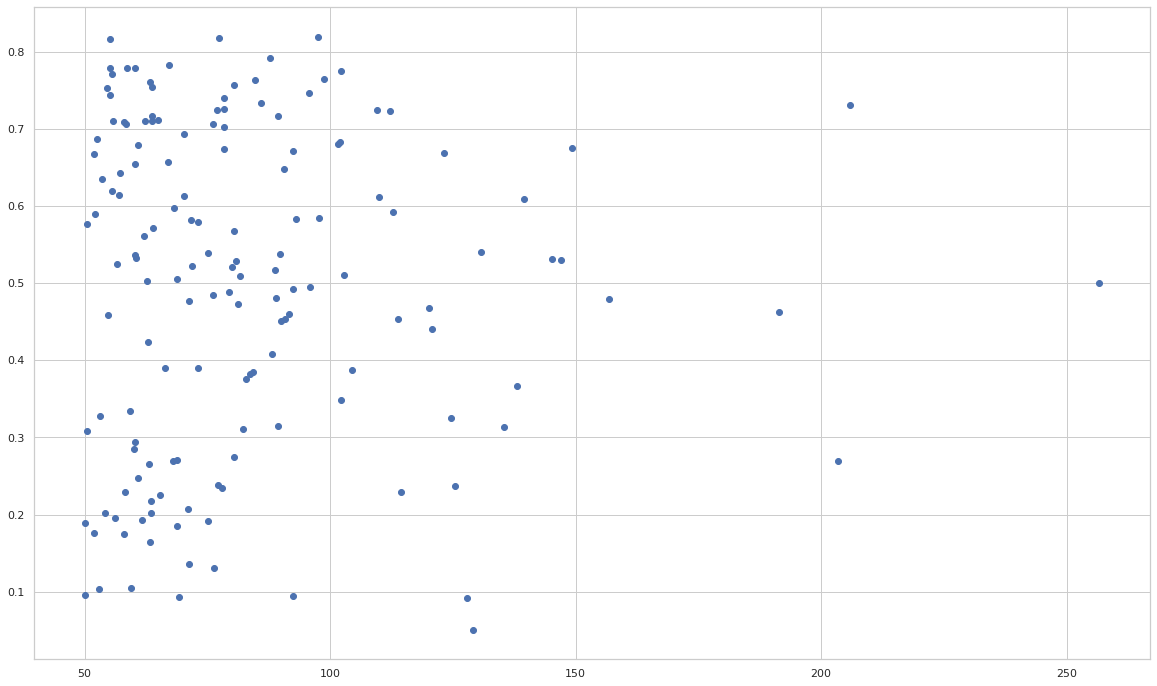

In [ ]:
err = (wm1ep.H - m7ep.H).abs()[:-1]
get_ax().scatter(err[err > 50], wm1_good_dir[1:][err>50])

### M506

<AxesSubplot:>

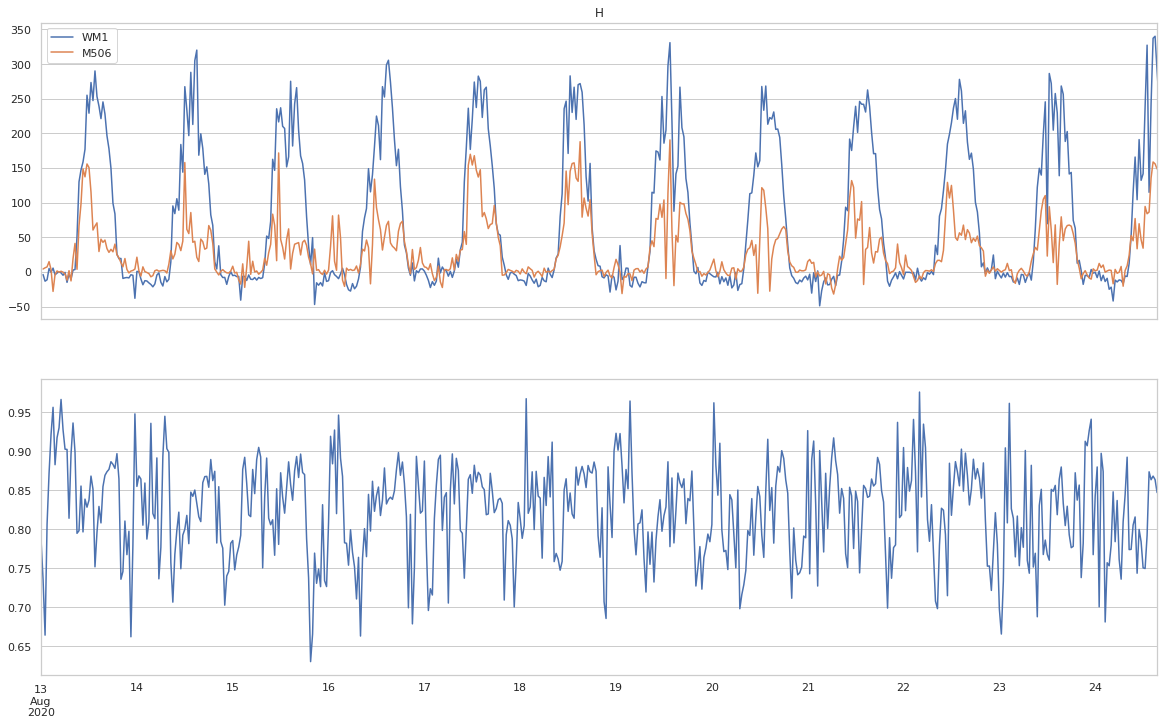

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True)
plot_components([wm1ep, m6ep], ['H'], ax=axes[0], plot_info=[{'label': 'WM1'}, {'label': 'M506'}])
wm1_good_aoa.plot(ax=axes[1])

## Nice plots

In [ ]:
wind_data = pd.concat(
    map(
    lambda x: x[0].assign(anem=x[1]),
    zip([wm1ep, m6ep, m7ep], ['wm1', 'm6', 'm7']))
)
wind_data.anem = pd.Categorical(wind_data.anem)

In [ ]:
wind_data.query('anem == "wm1"')

u         v         w  wind_speed  wind_dir  \
date_time                                                                 
2020-08-13 00:30:00 -0.119133 -0.144078  0.023493    0.188436  328.4370   
2020-08-13 01:00:00 -0.025795  0.099129 -0.028449    0.106318   46.5435   
2020-08-13 01:30:00 -0.067851 -0.023952 -0.008345    0.072461  335.2050   
2020-08-13 02:00:00 -0.101247 -0.022590  0.007594    0.104050  332.9120   
2020-08-13 02:30:00 -0.311380 -0.008679  0.026105    0.312621  347.2060   
...                       ...       ...       ...         ...       ...   
2020-08-24 14:00:00  0.569875 -2.047630 -0.138565    2.129990  257.3640   
2020-08-24 14:30:00  0.472314 -2.151450 -0.023897    2.202890  260.1850   
2020-08-24 15:00:00  0.043367 -2.392710  0.066899    2.394130  270.9670   
2020-08-24 15:30:00  0.072662 -2.161720 -0.027387    2.163260  269.6240   
2020-08-24 16:00:00  0.625276 -2.045540 -0.096164    2.141150  257.2990   

                          Tau          H        t        u* anem  
date_time                                                         
2020-08-13 00:30:00  0.010105   -3.70411  298.017  0.094176  wm1  
2020-08-13 01:00:00  0.019126  -13.26780  298.138  0.129591  wm1  
2020-08-13 01:30:00  0.017514  -11.26680  298.473  0.124083  wm1  
2020-08-13 02:00:00  0.002515    5.02356  297.608  0.046950  wm1  
2020-08-13 02:30:00  0.007737   -0.40778  296.482  0.082197  wm1  
...                       ...        ...      ...       ...  ...  
2020-08-24 14:00:00 -0.112127  243.22500  305.842  0.317807  wm1  
2020-08-24 14:30:00 -0.271925  337.36900  305.969  0.495022  wm1  
2020-08-24 15:00:00 -0.404275  340.22200  305.616  0.603236  wm1  
2020-08-24 15:30:00 -0.261856  290.35500  305.324  0.485258  wm1  
2020-08-24 16:00:00 -0.304101  244.54500  304.701  0.522405  wm1  

[560 rows x 10 columns]

**Rotate WM1 components** EP does not rotate them according to installation offset

In [ ]:
data.dtypes

u              float64
v              float64
w              float64
wind_speed     float64
wind_dir       float64
Tau            float64
H              float64
t              float64
u*             float64
anem          category
dtype: object

In [ ]:
data

u         v         w  wind_speed   wind_dir  \
date_time                                                                  
2020-08-10 15:00:00  0.592734 -1.856710 -0.117873    1.952660  254.84700   
2020-08-10 15:30:00 -0.137880 -2.195340  0.004207    2.199810  274.36000   
2020-08-10 16:00:00  0.145467 -2.095640 -0.013016    2.100830  268.09400   
2020-08-10 16:30:00  0.697851 -1.936100 -0.069184    2.059290  253.07900   
2020-08-10 17:00:00  0.591637 -1.714100 -0.138436    1.818680  253.39700   
...                       ...       ...       ...         ...        ...   
2020-08-13 07:30:00 -0.073485 -0.195485  0.079466    0.223478  293.64200   
2020-08-13 08:00:00 -0.061273 -0.341399  0.122776    0.367974  284.44000   
2020-08-13 08:30:00 -0.641903  0.287413  0.107620    0.711584   22.13170   
2020-08-13 09:00:00 -0.350018  0.311671  0.042034    0.470569   38.73340   
2020-08-13 09:30:00 -0.164409  0.040407  0.091730    0.192584    9.58732   

                          Tau         H        t        u*   anem time_day  \
date_time                                                                    
2020-08-10 15:00:00 -0.161664  164.3520  309.123  0.383649    wm1    15:00   
2020-08-10 15:30:00 -0.200517  236.7280  309.208  0.427329    wm1    15:30   
2020-08-10 16:00:00 -0.286764  245.7470  309.173  0.511003    wm1    16:00   
2020-08-10 16:30:00 -0.255489  215.3330  309.105  0.482281    wm1    16:30   
2020-08-10 17:00:00 -0.142132  145.2730  308.722  0.359494    wm1    17:00   
...                       ...       ...      ...       ...    ...      ...   
2020-08-13 07:30:00  0.021742  -16.5669  296.907  0.135245  mytrs    07:30   
2020-08-13 08:00:00 -0.063508  -28.0143  298.315  0.231695  mytrs    08:00   
2020-08-13 08:30:00  0.023925  -40.6602  298.970  0.142367  mytrs    08:30   
2020-08-13 09:00:00 -0.021403   16.3595  300.193  0.134928  mytrs    09:00   
2020-08-13 09:30:00 -0.044599   35.4965  300.565  0.194894  mytrs    09:30   

                        wind_dir_binned  
date_time                                
2020-08-10 15:00:00  (224.635, 269.462]  
2020-08-10 15:30:00   (269.462, 314.29]  
2020-08-10 16:00:00  (224.635, 269.462]  
2020-08-10 16:30:00  (224.635, 269.462]  
2020-08-10 17:00:00  (224.635, 269.462]  
...                                 ...  
2020-08-13 07:30:00   (269.462, 314.29]  
2020-08-13 08:00:00   (269.462, 314.29]  
2020-08-13 08:30:00     (0.139, 45.325]  
2020-08-13 09:00:00     (0.139, 45.325]  
2020-08-13 09:30:00     (0.139, 45.325]  

[528 rows x 12 columns]

In [ ]:
wind_data = add_time_of_day(wind_data)

<AxesSubplot:xlabel='time_day', ylabel='wind_speed'>

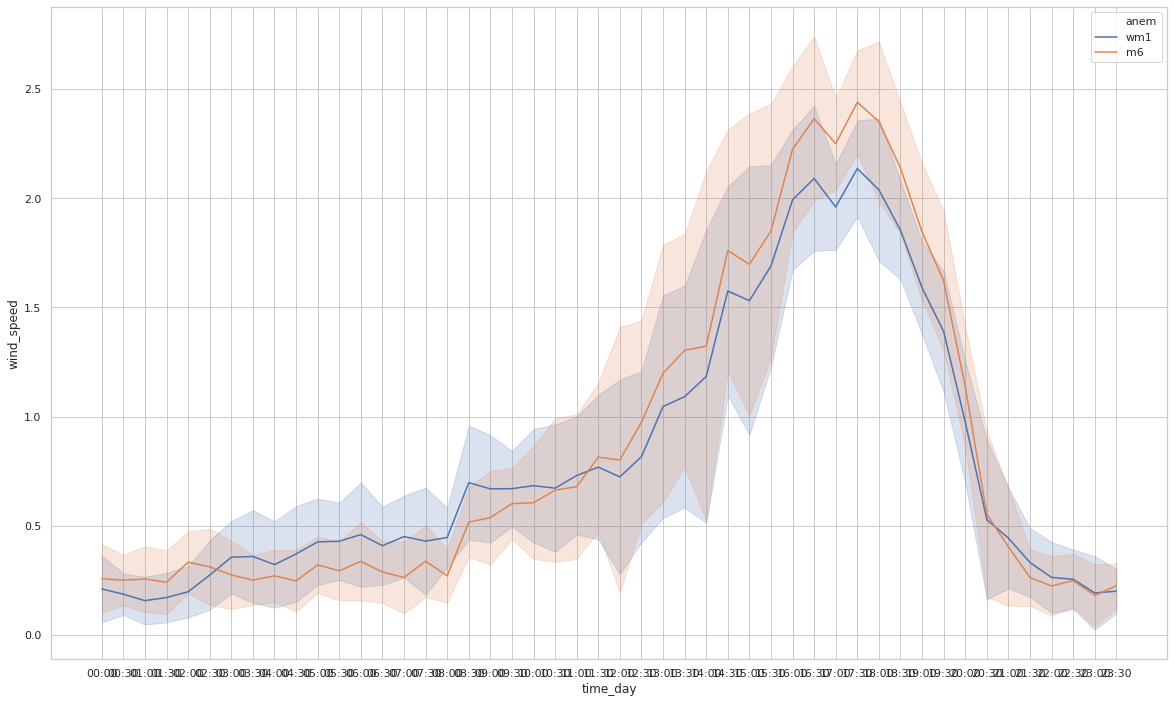

In [ ]:
sns.lineplot(x='time_day', y='wind_speed', hue='anem', ci='sd', data=wind_data.query('anem == "wm1" or anem == "m6"'), ax=get_ax())

In [ ]:
wind_data['wind_dir_binned']

date_time
2020-08-13 00:30:00    315.0
2020-08-13 01:00:00     45.0
2020-08-13 01:30:00    315.0
2020-08-13 02:00:00    315.0
2020-08-13 02:30:00    337.5
                       ...  
2020-08-24 14:00:00    225.0
2020-08-24 14:30:00    225.0
2020-08-24 15:00:00    225.0
2020-08-24 15:30:00    225.0
2020-08-24 16:00:00    225.0
Name: wind_dir_binned, Length: 1680, dtype: category
Categories (16, float64): [0.0, 22.5, 45.0, 67.5, ..., 270.0, 292.5, 315.0, 337.5]

In [ ]:
wind_data = add_wind_dir_binned(wind_data, 16)

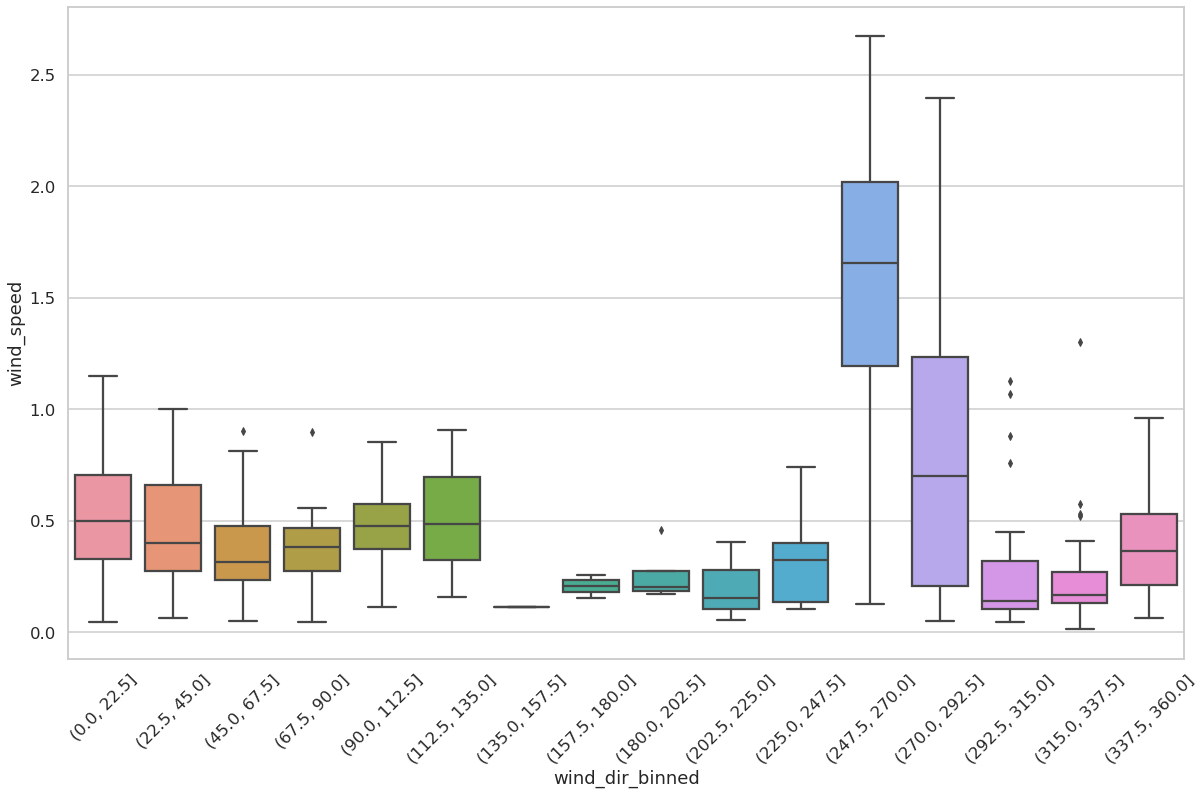

In [ ]:
sns.boxplot(x='wind_dir_binned', y='wind_speed',data=wind_data.query('anem == "wm1"'), ax=get_ax())
plt.tick_params(axis='x', rotation=45)

In [ ]:
err = wm1ep.wind_speed - m6ep.wind_speed

In [ ]:
err_perc = err.abs() / wm1ep.wind_speed

In [ ]:
err_perc.describe()

count    560.000000
mean       0.378655
std        0.574118
min        0.000901
25%        0.134657
50%        0.207025
75%        0.408811
max        6.404931
Name: wind_speed, dtype: float64

In [ ]:
err_perc

date_time
2020-08-13 00:30:00    0.549900
2020-08-13 01:00:00    0.607376
2020-08-13 01:30:00    0.071682
2020-08-13 02:00:00    1.755435
2020-08-13 02:30:00    0.171169
                         ...   
2020-08-24 14:00:00    0.102277
2020-08-24 14:30:00    0.098121
2020-08-24 15:00:00    0.049321
2020-08-24 15:30:00    0.048039
2020-08-24 16:00:00    0.065278
Name: wind_speed, Length: 560, dtype: float64

<AxesSubplot:xlabel='wind_speed'>

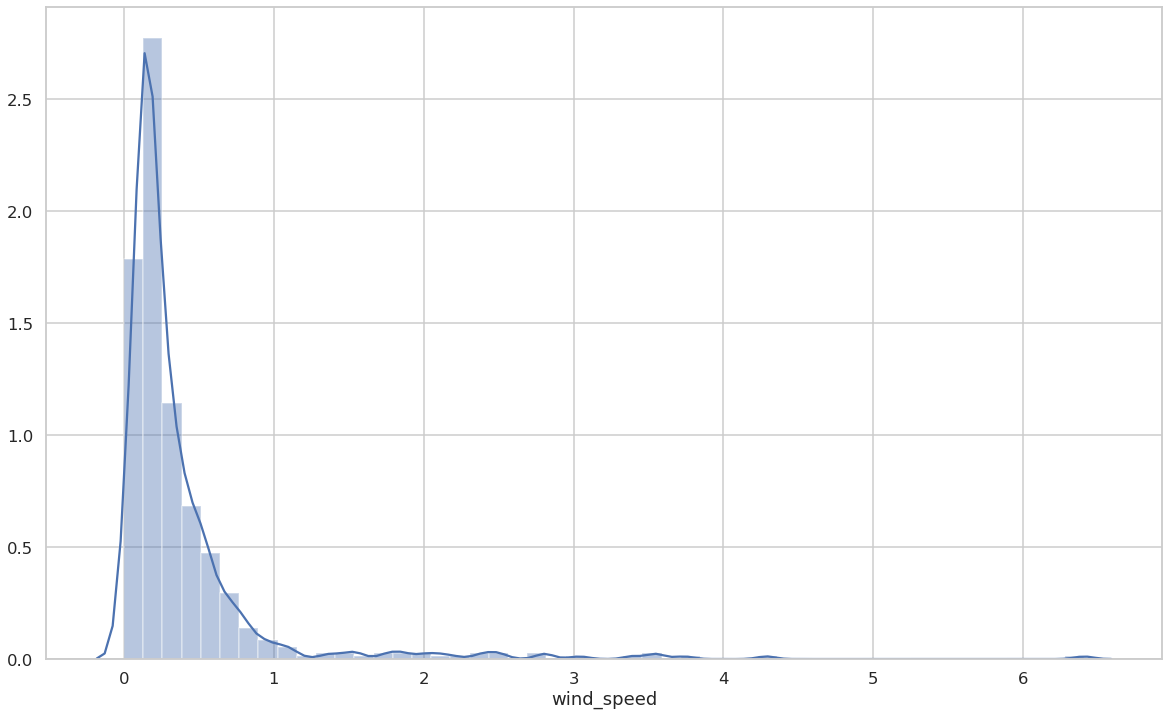

In [ ]:
sns.distplot(err_perc)

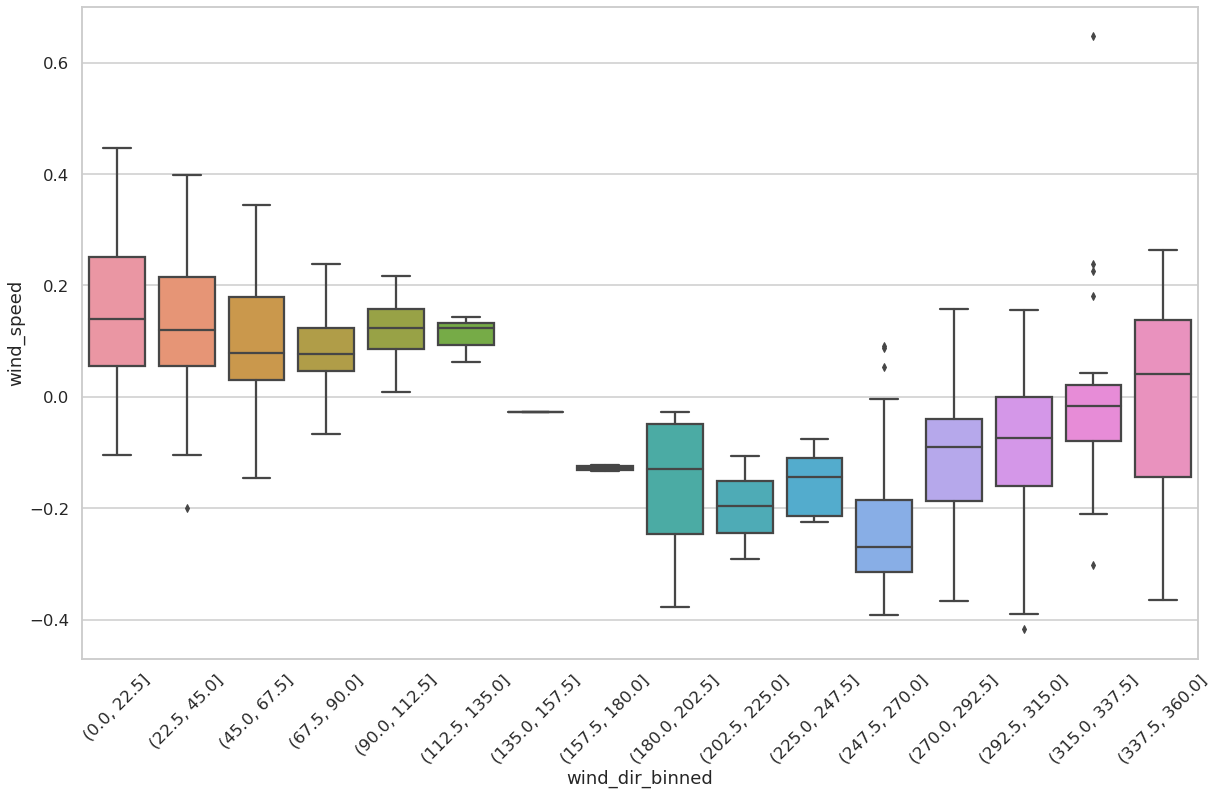

In [ ]:
sns.boxplot(x=wind_data.query('anem == "wm1"')['wind_dir_binned'], y=err, ax=get_ax())
plt.tick_params(axis='x', rotation=45)

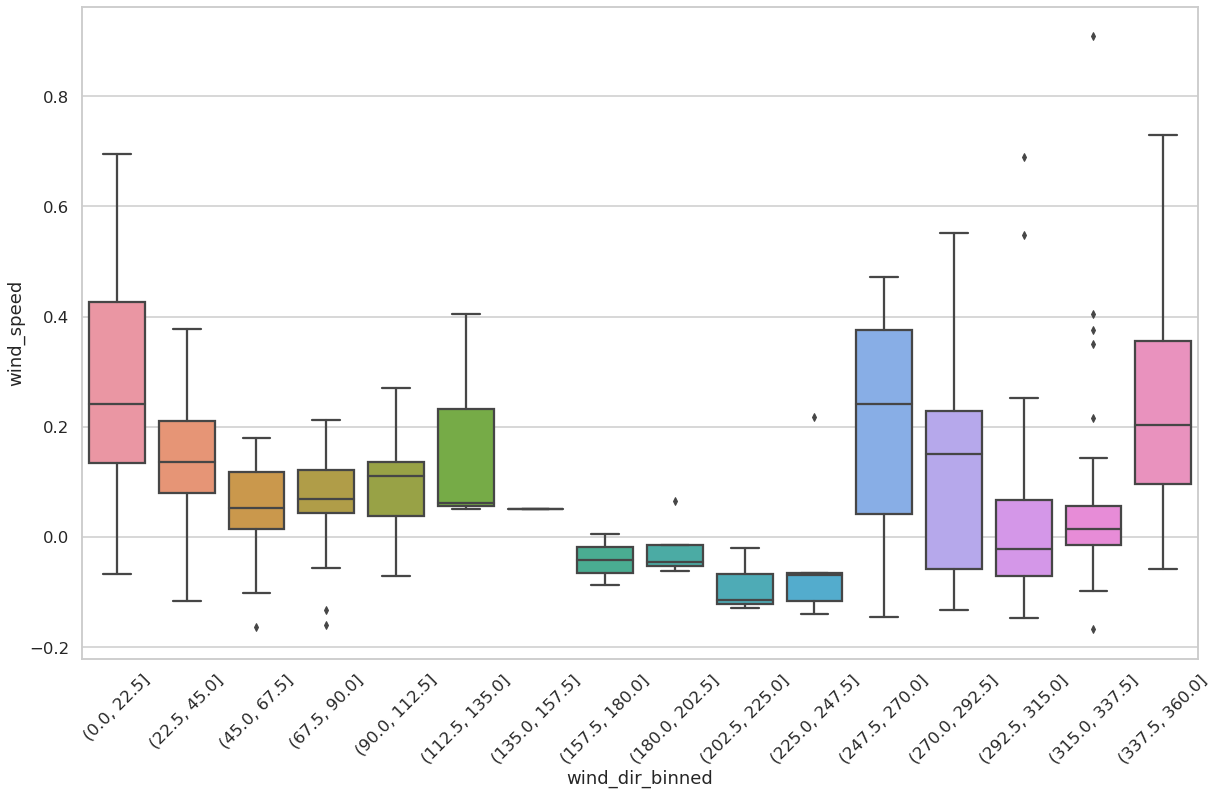

In [ ]:
sns.boxplot(x=wind_data.query('anem == "wm1"')['wind_dir_binned'], y=wm1ep.wind_speed - m7ep.wind_speed, ax=get_ax())
plt.tick_params(axis='x', rotation=45)

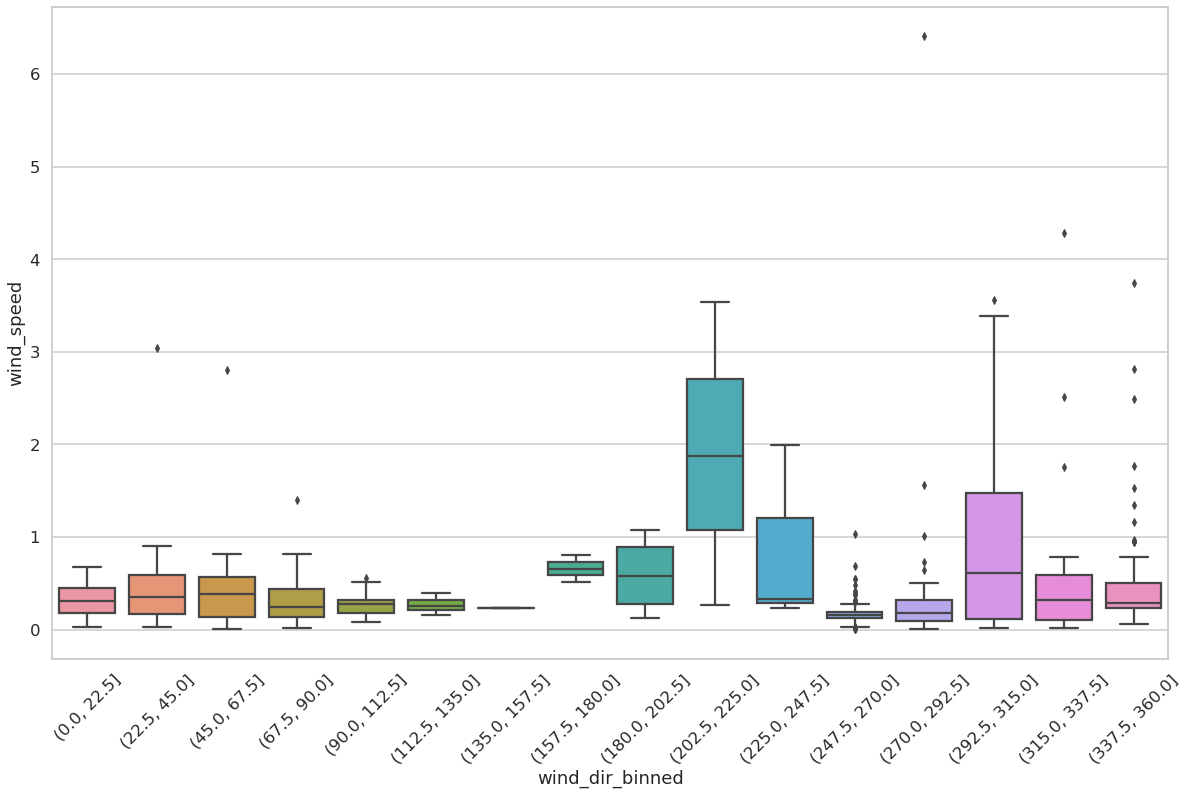

In [ ]:
sns.boxplot(x=wind_data.query('anem == "wm1"')['wind_dir_binned'], y=err_perc, ax=get_ax())
plt.tick_params(axis='x', rotation=45)